In [52]:
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import math

from tqdm import tqdm

## Model definition

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [54]:
# creazione del generatore

class Generator(nn.Module):
    def __init__(self, input_dim=100, n1=512, channels=3, width=64, height=64):
        super(Generator, self).__init__()

        self.fc = nn.Linear(input_dim, n1 * 4 * 4)

        self.conv_blocks = nn.Sequential(
            # BatchNorm after projection
            nn.BatchNorm2d(n1),
            
            # Block 1: (512, 4, 4) -> (256, 8, 8)
            nn.ConvTranspose2d(n1, n1//2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(n1//2),
            nn.ReLU(inplace=True),
            
            # Block 2: (256, 8, 8) -> (128, 16, 16)
            nn.ConvTranspose2d(n1//2, n1//4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(n1//4),
            nn.ReLU(inplace=True),
            
            # Block 3: (128, 16, 16) -> (64, 32, 32)
            nn.ConvTranspose2d(n1//4, n1//8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(n1//8),
            nn.ReLU(inplace=True),
            
            # Block 4: (64, 32, 32) -> (3, 64, 64)
            nn.ConvTranspose2d(n1//8, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)

        x = self.conv_blocks(x)
        return x

In [ ]:
NUM_DIMS = 100
image_size = (64, 64)

gen = Generator(input_dim=NUM_DIMS, n1=512, channels=3, width=image_size[0], height=image_size[1])
gen.to(device)

# Ottieni una sintesi dell'architettura
summary(gen, (NUM_DIMS,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         827,392
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
   ConvTranspose2d-3            [-1, 256, 8, 8]       2,097,408
       BatchNorm2d-4            [-1, 256, 8, 8]             512
              ReLU-5            [-1, 256, 8, 8]               0
   ConvTranspose2d-6          [-1, 128, 16, 16]         524,416
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
   ConvTranspose2d-9           [-1, 64, 32, 32]         131,136
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
  ConvTranspose2d-12            [-1, 3, 64, 64]           3,075
             Tanh-13            [-1, 3, 64, 64]               0
Total params: 3,585,347
Trainable param

In [56]:
# creazione del discriminatore

class Discriminator(nn.Module):
    def __init__(self, width, height, channels, n1=512, droprate=0.5):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: (3, 64, 64) -> (64, 32, 32)
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(droprate),
            
            # (64, 32, 32) -> (128, 16, 16)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(droprate),
            
            # (128, 16, 16) -> (256, 8, 8)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(droprate),
            
            # (256, 8, 8) -> (512, 4, 4)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(droprate),
            
            # Flatten and output
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
disc = Discriminator(width=image_size[0], height=image_size[1], channels=3, droprate=0.5)
disc.to(device)

# Ottieni una sintesi dell'architettura
summary(disc, (3, image_size[0], image_size[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,200
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 256, 8, 8]         524,544
       BatchNorm2d-9            [-1, 256, 8, 8]             512
        LeakyReLU-10            [-1, 256, 8, 8]               0
        Dropout2d-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        LeakyReLU-14            [-1, 51

In [58]:
disc_optimizer = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_optimizer  = optim.Adam(gen.parameters(),  lr=0.0002, betas=(0.5, 0.999))

disc_loss_function = nn.BCELoss()
gen_loss_function = nn.BCELoss()


##Now define the data loading generator

In [59]:

# add some data augmentation since the dataset size is small
train_transform = transforms.Compose([
    transforms.Resize((image_size[0], image_size[1])),
    transforms.RandomAffine(degrees=0, shear=(-0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
import os
import zipfile
from pathlib import Path

# Percorso della cartella LAB7
lab7_path = r"c:\Users\dorot\OneDrive - Politecnico di Torino\Desktop\Magistrale\Secondo Anno Magistrale\Machine Learning for Visual and Multimedia\Labs\LAB7"

# File ZIP
zip_file = os.path.join(lab7_path, "Christmas Tree-20211209T211340Z-001.zip")
extract_dir = os.path.join(lab7_path, "Christmas Tree-20211209T211340Z-001")

# Se non è stato estratto, estraiamo il ZIP
if not os.path.exists(extract_dir) and os.path.exists(zip_file):
    print(f"Estraendo {zip_file}...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(lab7_path)
    print("Estrazione completata!")

# Controlla se la cartella estratta esiste
if os.path.exists(extract_dir):
    christmas_tree_path = os.path.join(extract_dir, "Christmas Tree")
    if os.path.exists(christmas_tree_path):
        directory = os.path.join(christmas_tree_path, "0")
    else:
        directory = os.path.join(extract_dir, "0")
else:
    directory = os.path.join(lab7_path, "Christmas Tree", "0")

# Verifica che la cartella esista
if os.path.exists(directory):
    training_size = len(os.listdir(directory))
    print(f"✓ Dataset size: {training_size} images")
    print(f"Dataset path: {directory}")
else:
    print(f"✗ Cartella non trovata: {directory}")
    print("Cartelle disponibili:")
    if os.path.exists(lab7_path):
        print(os.listdir(lab7_path))

✓ Dataset size: 1896 images
Dataset path: c:\Users\dorot\OneDrive - Politecnico di Torino\Desktop\Magistrale\Secondo Anno Magistrale\Machine Learning for Visual and Multimedia\Labs\LAB7\Christmas Tree-20211209T211340Z-001\Christmas Tree\0


In [61]:
BATCH_SIZE = 128

# Usa il percorso della cartella estratta
lab7_path = r"c:\Users\dorot\OneDrive - Politecnico di Torino\Desktop\Magistrale\Secondo Anno Magistrale\Machine Learning for Visual and Multimedia\Labs\LAB7"
extract_dir = os.path.join(lab7_path, "Christmas Tree-20211209T211340Z-001")

# Trova il percorso corretto del dataset
if os.path.exists(os.path.join(extract_dir, "Christmas Tree")):
    dataset_root = os.path.join(extract_dir, "Christmas Tree")
else:
    dataset_root = extract_dir

train_dataset = ImageFolder(root=dataset_root, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"DataLoader creato con {len(train_dataset)} immagini")

DataLoader creato con 1896 immagini


In [62]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


def plot_figures(x, n):
    plt.imshow(np.transpose(vutils.make_grid(x.to(device)[:n], padding=2, normalize=True).cpu(),(1,2,0)))

    plt.show()


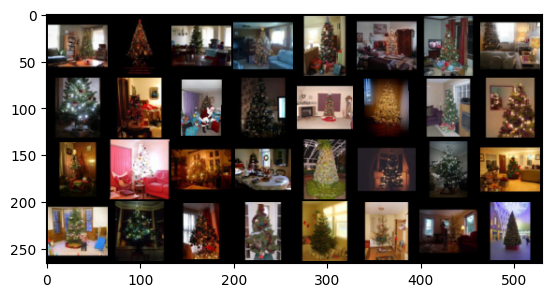

In [63]:
images, _ = next(iter(train_loader))

plot_figures(images, 32)

## Now train for a given number of epochs

In [64]:
import matplotlib.pyplot as plt

In [65]:
batchesPerEpoch = int(training_size / BATCH_SIZE)
print(batchesPerEpoch)

14


In [66]:
benchmarkNoise = torch.randn(BATCH_SIZE, NUM_DIMS, device=device)

In [67]:
def train_gan(train_loader, num_epochs, batch_size, num_dims):
    history = {
        'G_loss': [],
        'D_loss_true': [],
        'D_loss_fake': []
    }
    accuracy = {
        'Acc_true': [],
        'Acc_fake': []
    }
    real_label = 1.0
    fake_label = 0.0
    
    for epoch in range(num_epochs):
        epoch_d_loss_real = 0
        epoch_d_loss_fake = 0
        epoch_g_loss = 0
        epoch_acc_real = 0
        epoch_acc_fake = 0
        
        for i, (real_images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            batch_size_actual = real_images.size(0)
            real_images = real_images.to(device)
            
            # ========== TRAIN DISCRIMINATOR ==========
            disc.zero_grad()
            
            # Train on real images
            labels_real = torch.full((batch_size_actual, 1), real_label, device=device)
            output_real = disc(real_images)
            disc_loss_real = disc_loss_function(output_real, labels_real)
            disc_loss_real.backward()
            
            # Calculate accuracy on real images
            acc_real = (output_real > 0.5).float().mean().item()
            
            # Train on fake images
            noise = torch.randn(batch_size_actual, num_dims, device=device)
            fake_images = gen(noise)
            labels_fake = torch.full((batch_size_actual, 1), fake_label, device=device)
            output_fake = disc(fake_images.detach())
            disc_loss_fake = disc_loss_function(output_fake, labels_fake)
            disc_loss_fake.backward()
            
            # Calculate accuracy on fake images
            acc_fake = (output_fake < 0.5).float().mean().item()
            
            # Update discriminator
            disc_optimizer.step()
            
            # ========== TRAIN GENERATOR ==========
            gen.zero_grad()
            
            # Generate fake images and try to fool discriminator
            noise = torch.randn(batch_size_actual, num_dims, device=device)
            fake_images = gen(noise)
            labels_real_for_gen = torch.full((batch_size_actual, 1), real_label, device=device)
            output_fake_for_gen = disc(fake_images)
            gan_loss = gan_loss_function(output_fake_for_gen, labels_real_for_gen)
            gan_loss.backward()
            
            # Update generator
            gen_optimizer.step()
            
            # Accumulate losses
            epoch_d_loss_real += disc_loss_real.item()
            epoch_d_loss_fake += disc_loss_fake.item()
            epoch_g_loss += gan_loss.item()
            epoch_acc_real += acc_real
            epoch_acc_fake += acc_fake
        
        # Average losses over epoch
        avg_d_loss_real = epoch_d_loss_real / batchesPerEpoch
        avg_d_loss_fake = epoch_d_loss_fake / batchesPerEpoch
        avg_g_loss = epoch_g_loss / batchesPerEpoch
        avg_acc_real = epoch_acc_real / batchesPerEpoch
        avg_acc_fake = epoch_acc_fake / batchesPerEpoch
        
        # Store history
        history['D_loss_true'].append(avg_d_loss_real)
        history['D_loss_fake'].append(avg_d_loss_fake)
        history['G_loss'].append(avg_g_loss)
        accuracy['Acc_true'].append(avg_acc_real)
        accuracy['Acc_fake'].append(avg_acc_fake)
        
        # Print progress
        print(f"Epoch {epoch+1}: D_loss_real={avg_d_loss_real:.4f}, "
              f"D_loss_fake={avg_d_loss_fake:.4f}, G_loss={avg_g_loss:.4f}, "
              f"Acc_real={avg_acc_real:.4f}, Acc_fake={avg_acc_fake:.4f}")
        
        # Visualize progress every 10 epochs
        if epoch % 10 == 0:
            gen.eval()
            with torch.no_grad():
                images = gen(benchmarkNoise)
            gen.train()
            # Use your plot_figures function here
            # plot_figures(images, 4)
        
        # Save checkpoints
        if (epoch % 100) == 0:
            torch.save({
                'disc_state_dict': disc.state_dict(),
                'gen_state_dict': gen.state_dict(),
                'disc_optimizer_state_dict': disc_optimizer.state_dict(),
                'gen_optimizer_state_dict': gen_optimizer.state_dict(),
                'epoch': epoch,
                'history': history,
                'accuracy': accuracy
            }, f"model64_epoch_{epoch}.pth")
    
    return history, accuracy

In [68]:
history, accuracy = train_gan(train_loader, num_epochs=500, batch_size=BATCH_SIZE, num_dims=NUM_DIMS)

Epoch 1/500: 100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


Epoch 1: D_loss_real=0.3550, D_loss_fake=0.3535, G_loss=2.7001, Acc_real=0.9406, Acc_fake=0.9712


Epoch 2/500: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Epoch 2: D_loss_real=0.1932, D_loss_fake=0.1637, G_loss=5.0045, Acc_real=1.0023, Acc_fake=1.0341


Epoch 3/500: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 3: D_loss_real=0.2199, D_loss_fake=0.2037, G_loss=6.1917, Acc_real=0.9855, Acc_fake=0.9988


Epoch 4/500: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


Epoch 4: D_loss_real=0.5641, D_loss_fake=0.4470, G_loss=5.6898, Acc_real=0.8240, Acc_fake=0.8749


Epoch 5/500: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


Epoch 5: D_loss_real=0.4855, D_loss_fake=0.3372, G_loss=3.8035, Acc_real=0.8440, Acc_fake=0.9352


Epoch 6/500: 100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


Epoch 6: D_loss_real=0.5171, D_loss_fake=0.4362, G_loss=3.1557, Acc_real=0.8252, Acc_fake=0.8638


Epoch 7/500: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 7: D_loss_real=0.5055, D_loss_fake=0.4638, G_loss=2.2064, Acc_real=0.8208, Acc_fake=0.8588


Epoch 8/500: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


Epoch 8: D_loss_real=0.5145, D_loss_fake=0.4723, G_loss=2.1219, Acc_real=0.8176, Acc_fake=0.8623


Epoch 9/500: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


Epoch 9: D_loss_real=0.4876, D_loss_fake=0.4592, G_loss=2.1410, Acc_real=0.8437, Acc_fake=0.8713


Epoch 10/500: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch 10: D_loss_real=0.5464, D_loss_fake=0.5079, G_loss=2.0709, Acc_real=0.7855, Acc_fake=0.8354


Epoch 11/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 11: D_loss_real=0.5433, D_loss_fake=0.5485, G_loss=1.9824, Acc_real=0.8057, Acc_fake=0.7982


Epoch 12/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 12: D_loss_real=0.5684, D_loss_fake=0.5463, G_loss=1.8269, Acc_real=0.7785, Acc_fake=0.8045


Epoch 13/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 13: D_loss_real=0.5574, D_loss_fake=0.5253, G_loss=2.0945, Acc_real=0.7967, Acc_fake=0.8217


Epoch 14/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 14: D_loss_real=0.4771, D_loss_fake=0.4643, G_loss=2.2727, Acc_real=0.8435, Acc_fake=0.8626


Epoch 15/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 15: D_loss_real=0.4587, D_loss_fake=0.4309, G_loss=2.4920, Acc_real=0.8571, Acc_fake=0.8856


Epoch 16/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 16: D_loss_real=0.4922, D_loss_fake=0.4367, G_loss=2.4812, Acc_real=0.8391, Acc_fake=0.8815


Epoch 17/500: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 17: D_loss_real=0.4390, D_loss_fake=0.3932, G_loss=2.6487, Acc_real=0.8731, Acc_fake=0.9040


Epoch 18/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 18: D_loss_real=0.5140, D_loss_fake=0.4561, G_loss=2.4466, Acc_real=0.8184, Acc_fake=0.8691


Epoch 19/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 19: D_loss_real=0.5174, D_loss_fake=0.5046, G_loss=2.2648, Acc_real=0.8113, Acc_fake=0.8333


Epoch 20/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 20: D_loss_real=0.5990, D_loss_fake=0.5838, G_loss=2.1728, Acc_real=0.7745, Acc_fake=0.7791


Epoch 21/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 21: D_loss_real=0.5378, D_loss_fake=0.4945, G_loss=2.2645, Acc_real=0.8165, Acc_fake=0.8343


Epoch 22/500: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 22: D_loss_real=0.4788, D_loss_fake=0.5108, G_loss=2.2867, Acc_real=0.8413, Acc_fake=0.8100


Epoch 23/500: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 23: D_loss_real=0.5403, D_loss_fake=0.4720, G_loss=2.2247, Acc_real=0.8028, Acc_fake=0.8479


Epoch 24/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 24: D_loss_real=0.4779, D_loss_fake=0.4922, G_loss=2.2841, Acc_real=0.8498, Acc_fake=0.8392


Epoch 25/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 25: D_loss_real=0.4975, D_loss_fake=0.5011, G_loss=2.2462, Acc_real=0.8229, Acc_fake=0.8362


Epoch 26/500: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Epoch 26: D_loss_real=0.4760, D_loss_fake=0.4853, G_loss=2.3520, Acc_real=0.8520, Acc_fake=0.8519


Epoch 27/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 27: D_loss_real=0.4488, D_loss_fake=0.4169, G_loss=2.3987, Acc_real=0.8682, Acc_fake=0.8853


Epoch 28/500: 100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Epoch 28: D_loss_real=0.5321, D_loss_fake=0.6129, G_loss=2.6577, Acc_real=0.8140, Acc_fake=0.7752


Epoch 29/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 29: D_loss_real=0.6041, D_loss_fake=0.5690, G_loss=2.1932, Acc_real=0.7657, Acc_fake=0.7816


Epoch 30/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 30: D_loss_real=0.5751, D_loss_fake=0.5352, G_loss=2.1711, Acc_real=0.7970, Acc_fake=0.8274


Epoch 31/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 31: D_loss_real=0.4380, D_loss_fake=0.4482, G_loss=2.5422, Acc_real=0.8799, Acc_fake=0.8733


Epoch 32/500: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 32: D_loss_real=0.4560, D_loss_fake=0.4618, G_loss=2.2545, Acc_real=0.8747, Acc_fake=0.8643


Epoch 33/500: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


Epoch 33: D_loss_real=0.5550, D_loss_fake=0.5394, G_loss=2.3459, Acc_real=0.7991, Acc_fake=0.8095


Epoch 34/500: 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 34: D_loss_real=0.5352, D_loss_fake=0.5195, G_loss=2.2035, Acc_real=0.8117, Acc_fake=0.8206


Epoch 35/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 35: D_loss_real=0.4781, D_loss_fake=0.4822, G_loss=2.2753, Acc_real=0.8593, Acc_fake=0.8440


Epoch 36/500: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 36: D_loss_real=0.4842, D_loss_fake=0.4958, G_loss=2.3358, Acc_real=0.8457, Acc_fake=0.8394


Epoch 37/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 37: D_loss_real=0.5362, D_loss_fake=0.5173, G_loss=2.2178, Acc_real=0.8023, Acc_fake=0.8244


Epoch 38/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 38: D_loss_real=0.4968, D_loss_fake=0.4954, G_loss=2.5189, Acc_real=0.8357, Acc_fake=0.8307


Epoch 39/500: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Epoch 39: D_loss_real=0.6156, D_loss_fake=0.6193, G_loss=2.3451, Acc_real=0.7622, Acc_fake=0.7923


Epoch 40/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 40: D_loss_real=0.5103, D_loss_fake=0.5117, G_loss=2.1670, Acc_real=0.8304, Acc_fake=0.8357


Epoch 41/500: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch 41: D_loss_real=0.5800, D_loss_fake=0.5419, G_loss=2.0071, Acc_real=0.7855, Acc_fake=0.8046


Epoch 42/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 42: D_loss_real=0.4757, D_loss_fake=0.4923, G_loss=2.0711, Acc_real=0.8540, Acc_fake=0.8404


Epoch 43/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 43: D_loss_real=0.5547, D_loss_fake=0.5495, G_loss=2.2263, Acc_real=0.7874, Acc_fake=0.7968


Epoch 44/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 44: D_loss_real=0.4974, D_loss_fake=0.5312, G_loss=2.4356, Acc_real=0.8446, Acc_fake=0.8098


Epoch 45/500: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Epoch 45: D_loss_real=0.6545, D_loss_fake=0.5988, G_loss=2.1066, Acc_real=0.7223, Acc_fake=0.7942


Epoch 46/500: 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]


Epoch 46: D_loss_real=0.5025, D_loss_fake=0.5373, G_loss=2.0037, Acc_real=0.8489, Acc_fake=0.8204


Epoch 47/500: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


Epoch 47: D_loss_real=0.5944, D_loss_fake=0.5572, G_loss=2.0091, Acc_real=0.7761, Acc_fake=0.7933


Epoch 48/500: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Epoch 48: D_loss_real=0.4855, D_loss_fake=0.4910, G_loss=2.1964, Acc_real=0.8433, Acc_fake=0.8418


Epoch 49/500: 100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


Epoch 49: D_loss_real=0.5848, D_loss_fake=0.5561, G_loss=2.2365, Acc_real=0.8099, Acc_fake=0.8001


Epoch 50/500: 100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


Epoch 50: D_loss_real=0.5325, D_loss_fake=0.4989, G_loss=2.3575, Acc_real=0.8086, Acc_fake=0.8262


Epoch 51/500: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


Epoch 51: D_loss_real=0.5420, D_loss_fake=0.5710, G_loss=2.0814, Acc_real=0.8090, Acc_fake=0.7951


Epoch 52/500: 100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Epoch 52: D_loss_real=0.5863, D_loss_fake=0.5496, G_loss=1.9460, Acc_real=0.7708, Acc_fake=0.8021


Epoch 53/500: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Epoch 53: D_loss_real=0.5410, D_loss_fake=0.5180, G_loss=2.1127, Acc_real=0.7979, Acc_fake=0.8277


Epoch 54/500: 100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


Epoch 54: D_loss_real=0.5253, D_loss_fake=0.6176, G_loss=2.3666, Acc_real=0.8033, Acc_fake=0.7737


Epoch 55/500: 100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


Epoch 55: D_loss_real=0.6189, D_loss_fake=0.5693, G_loss=1.9962, Acc_real=0.7522, Acc_fake=0.7762


Epoch 56/500: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


Epoch 56: D_loss_real=0.5248, D_loss_fake=0.4722, G_loss=1.9627, Acc_real=0.8256, Acc_fake=0.8659


Epoch 57/500: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Epoch 57: D_loss_real=0.5236, D_loss_fake=0.5490, G_loss=1.7466, Acc_real=0.8119, Acc_fake=0.8025


Epoch 58/500: 100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


Epoch 58: D_loss_real=0.5799, D_loss_fake=0.5867, G_loss=1.9169, Acc_real=0.7825, Acc_fake=0.7719


Epoch 59/500: 100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


Epoch 59: D_loss_real=0.5639, D_loss_fake=0.5814, G_loss=1.8790, Acc_real=0.7810, Acc_fake=0.7717


Epoch 60/500: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Epoch 60: D_loss_real=0.4991, D_loss_fake=0.5246, G_loss=2.0866, Acc_real=0.8434, Acc_fake=0.8250


Epoch 61/500: 100%|██████████| 15/15 [00:05<00:00,  2.72it/s]


Epoch 61: D_loss_real=0.6091, D_loss_fake=0.5876, G_loss=2.1294, Acc_real=0.7516, Acc_fake=0.7846


Epoch 62/500: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Epoch 62: D_loss_real=0.5214, D_loss_fake=0.5442, G_loss=2.1135, Acc_real=0.8331, Acc_fake=0.8139


Epoch 63/500: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Epoch 63: D_loss_real=0.5507, D_loss_fake=0.5379, G_loss=1.8573, Acc_real=0.8190, Acc_fake=0.8145


Epoch 64/500: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


Epoch 64: D_loss_real=0.5827, D_loss_fake=0.5386, G_loss=1.9650, Acc_real=0.7733, Acc_fake=0.8091


Epoch 65/500: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Epoch 65: D_loss_real=0.5326, D_loss_fake=0.5152, G_loss=2.0125, Acc_real=0.8016, Acc_fake=0.8167


Epoch 66/500: 100%|██████████| 15/15 [00:05<00:00,  2.89it/s]


Epoch 66: D_loss_real=0.5917, D_loss_fake=0.5900, G_loss=2.0790, Acc_real=0.7851, Acc_fake=0.7656


Epoch 67/500: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


Epoch 67: D_loss_real=0.5826, D_loss_fake=0.5891, G_loss=1.8925, Acc_real=0.7749, Acc_fake=0.7700


Epoch 68/500: 100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


Epoch 68: D_loss_real=0.5983, D_loss_fake=0.6341, G_loss=2.0278, Acc_real=0.7495, Acc_fake=0.7401


Epoch 69/500: 100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Epoch 69: D_loss_real=0.5652, D_loss_fake=0.5132, G_loss=1.8357, Acc_real=0.7809, Acc_fake=0.8281


Epoch 70/500: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


Epoch 70: D_loss_real=0.5401, D_loss_fake=0.4988, G_loss=2.1622, Acc_real=0.7988, Acc_fake=0.8237


Epoch 71/500: 100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


Epoch 71: D_loss_real=0.5498, D_loss_fake=0.5479, G_loss=2.2336, Acc_real=0.8209, Acc_fake=0.7949


Epoch 72/500: 100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Epoch 72: D_loss_real=0.5047, D_loss_fake=0.5028, G_loss=2.0037, Acc_real=0.8389, Acc_fake=0.8356


Epoch 73/500: 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 73: D_loss_real=0.5712, D_loss_fake=0.5710, G_loss=2.0265, Acc_real=0.7763, Acc_fake=0.7946


Epoch 74/500: 100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Epoch 74: D_loss_real=0.5800, D_loss_fake=0.5860, G_loss=1.8747, Acc_real=0.7825, Acc_fake=0.7679


Epoch 75/500: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


Epoch 75: D_loss_real=0.5895, D_loss_fake=0.5704, G_loss=1.7871, Acc_real=0.7642, Acc_fake=0.7927


Epoch 76/500: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


Epoch 76: D_loss_real=0.5263, D_loss_fake=0.5831, G_loss=2.2689, Acc_real=0.7949, Acc_fake=0.7721


Epoch 77/500: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


Epoch 77: D_loss_real=0.5353, D_loss_fake=0.4777, G_loss=2.0402, Acc_real=0.7956, Acc_fake=0.8411


Epoch 78/500: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


Epoch 78: D_loss_real=0.6394, D_loss_fake=0.6684, G_loss=2.0571, Acc_real=0.7298, Acc_fake=0.7142


Epoch 79/500: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 79: D_loss_real=0.6158, D_loss_fake=0.5779, G_loss=1.8454, Acc_real=0.7637, Acc_fake=0.7655


Epoch 80/500: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Epoch 80: D_loss_real=0.5541, D_loss_fake=0.5185, G_loss=1.9196, Acc_real=0.8040, Acc_fake=0.8353


Epoch 81/500: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


Epoch 81: D_loss_real=0.6205, D_loss_fake=0.5863, G_loss=1.8617, Acc_real=0.7530, Acc_fake=0.7737


Epoch 82/500: 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 82: D_loss_real=0.5266, D_loss_fake=0.5940, G_loss=1.8866, Acc_real=0.8161, Acc_fake=0.7709


Epoch 83/500: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


Epoch 83: D_loss_real=0.6582, D_loss_fake=0.6363, G_loss=1.7699, Acc_real=0.7182, Acc_fake=0.7356


Epoch 84/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 84: D_loss_real=0.5328, D_loss_fake=0.4946, G_loss=1.8591, Acc_real=0.8221, Acc_fake=0.8522


Epoch 85/500: 100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Epoch 85: D_loss_real=0.5735, D_loss_fake=0.5832, G_loss=1.7331, Acc_real=0.7843, Acc_fake=0.7767


Epoch 86/500: 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


Epoch 86: D_loss_real=0.5935, D_loss_fake=0.5870, G_loss=1.7194, Acc_real=0.7704, Acc_fake=0.7692


Epoch 87/500: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 87: D_loss_real=0.6545, D_loss_fake=0.5959, G_loss=1.6857, Acc_real=0.7164, Acc_fake=0.7636


Epoch 88/500: 100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


Epoch 88: D_loss_real=0.4983, D_loss_fake=0.5408, G_loss=1.8161, Acc_real=0.8444, Acc_fake=0.8164


Epoch 89/500: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 89: D_loss_real=0.6109, D_loss_fake=0.5842, G_loss=1.9166, Acc_real=0.7625, Acc_fake=0.7813


Epoch 90/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 90: D_loss_real=0.6550, D_loss_fake=0.6009, G_loss=1.6900, Acc_real=0.7365, Acc_fake=0.7566


Epoch 91/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 91: D_loss_real=0.6200, D_loss_fake=0.6732, G_loss=1.6503, Acc_real=0.7767, Acc_fake=0.6892


Epoch 92/500: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch 92: D_loss_real=0.6886, D_loss_fake=0.6176, G_loss=1.6307, Acc_real=0.6878, Acc_fake=0.7544


Epoch 93/500: 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 93: D_loss_real=0.5701, D_loss_fake=0.5936, G_loss=1.3498, Acc_real=0.7782, Acc_fake=0.7621


Epoch 94/500: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 94: D_loss_real=0.5446, D_loss_fake=0.5587, G_loss=1.8156, Acc_real=0.8021, Acc_fake=0.7971


Epoch 95/500: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


Epoch 95: D_loss_real=0.5636, D_loss_fake=0.5006, G_loss=1.8825, Acc_real=0.7859, Acc_fake=0.8513


Epoch 96/500: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


Epoch 96: D_loss_real=0.6054, D_loss_fake=0.5597, G_loss=1.6804, Acc_real=0.7573, Acc_fake=0.7891


Epoch 97/500: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


Epoch 97: D_loss_real=0.6180, D_loss_fake=0.6104, G_loss=1.5821, Acc_real=0.7614, Acc_fake=0.7458


Epoch 98/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 98: D_loss_real=0.6429, D_loss_fake=0.5830, G_loss=1.5978, Acc_real=0.7401, Acc_fake=0.7810


Epoch 99/500: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 99: D_loss_real=0.6044, D_loss_fake=0.6059, G_loss=1.6919, Acc_real=0.7572, Acc_fake=0.7713


Epoch 100/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 100: D_loss_real=0.6595, D_loss_fake=0.6530, G_loss=1.6622, Acc_real=0.6993, Acc_fake=0.7130


Epoch 101/500: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch 101: D_loss_real=0.6358, D_loss_fake=0.5983, G_loss=1.5983, Acc_real=0.7363, Acc_fake=0.7681


Epoch 102/500: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


Epoch 102: D_loss_real=0.6196, D_loss_fake=0.6287, G_loss=1.6082, Acc_real=0.7500, Acc_fake=0.7401


Epoch 103/500: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch 103: D_loss_real=0.6077, D_loss_fake=0.6006, G_loss=1.4606, Acc_real=0.7511, Acc_fake=0.7577


Epoch 104/500: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 104: D_loss_real=0.5232, D_loss_fake=0.5373, G_loss=1.6992, Acc_real=0.8224, Acc_fake=0.8272


Epoch 105/500: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 105: D_loss_real=0.5503, D_loss_fake=0.5393, G_loss=1.7782, Acc_real=0.7957, Acc_fake=0.8192


Epoch 106/500: 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


Epoch 106: D_loss_real=0.7147, D_loss_fake=0.7050, G_loss=1.5906, Acc_real=0.7000, Acc_fake=0.6736


Epoch 107/500: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


Epoch 107: D_loss_real=0.5898, D_loss_fake=0.6030, G_loss=1.6003, Acc_real=0.7524, Acc_fake=0.7712


Epoch 108/500: 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 108: D_loss_real=0.6001, D_loss_fake=0.5518, G_loss=1.5220, Acc_real=0.7718, Acc_fake=0.8077


Epoch 109/500: 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


Epoch 109: D_loss_real=0.5883, D_loss_fake=0.5988, G_loss=1.7271, Acc_real=0.7643, Acc_fake=0.7656


Epoch 110/500: 100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


Epoch 110: D_loss_real=0.5834, D_loss_fake=0.5670, G_loss=1.5662, Acc_real=0.7774, Acc_fake=0.7846


Epoch 111/500: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


Epoch 111: D_loss_real=0.5843, D_loss_fake=0.5493, G_loss=1.6359, Acc_real=0.7627, Acc_fake=0.8003


Epoch 112/500: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


Epoch 112: D_loss_real=0.6514, D_loss_fake=0.6248, G_loss=1.3843, Acc_real=0.7259, Acc_fake=0.7399


Epoch 113/500: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


Epoch 113: D_loss_real=0.5054, D_loss_fake=0.5204, G_loss=1.7651, Acc_real=0.8404, Acc_fake=0.8293


Epoch 114/500: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch 114: D_loss_real=0.5577, D_loss_fake=0.5403, G_loss=1.6125, Acc_real=0.7922, Acc_fake=0.8183


Epoch 115/500: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch 115: D_loss_real=0.5800, D_loss_fake=0.5802, G_loss=1.5270, Acc_real=0.7747, Acc_fake=0.7891


Epoch 116/500: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


Epoch 116: D_loss_real=0.6365, D_loss_fake=0.6376, G_loss=1.5821, Acc_real=0.7312, Acc_fake=0.7419


Epoch 117/500: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


Epoch 117: D_loss_real=0.5845, D_loss_fake=0.6144, G_loss=1.5772, Acc_real=0.7809, Acc_fake=0.7510


Epoch 118/500: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


Epoch 118: D_loss_real=0.6194, D_loss_fake=0.5957, G_loss=1.7987, Acc_real=0.7609, Acc_fake=0.7452


Epoch 119/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 119: D_loss_real=0.6118, D_loss_fake=0.6573, G_loss=1.6640, Acc_real=0.7613, Acc_fake=0.7265


Epoch 120/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 120: D_loss_real=0.6100, D_loss_fake=0.5888, G_loss=1.5117, Acc_real=0.7709, Acc_fake=0.7697


Epoch 121/500: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 121: D_loss_real=0.5575, D_loss_fake=0.5585, G_loss=1.8027, Acc_real=0.8058, Acc_fake=0.7880


Epoch 122/500: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 122: D_loss_real=0.6003, D_loss_fake=0.5713, G_loss=1.6646, Acc_real=0.7625, Acc_fake=0.7828


Epoch 123/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 123: D_loss_real=0.6399, D_loss_fake=0.6627, G_loss=1.5893, Acc_real=0.7203, Acc_fake=0.7180


Epoch 124/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 124: D_loss_real=0.5775, D_loss_fake=0.5689, G_loss=1.7072, Acc_real=0.7697, Acc_fake=0.7896


Epoch 125/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 125: D_loss_real=0.6163, D_loss_fake=0.6150, G_loss=1.4819, Acc_real=0.7579, Acc_fake=0.7522


Epoch 126/500: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Epoch 126: D_loss_real=0.6016, D_loss_fake=0.5401, G_loss=1.4602, Acc_real=0.7456, Acc_fake=0.8051


Epoch 127/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 127: D_loss_real=0.5488, D_loss_fake=0.5836, G_loss=1.6448, Acc_real=0.8121, Acc_fake=0.7775


Epoch 128/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 128: D_loss_real=0.6584, D_loss_fake=0.6461, G_loss=1.5655, Acc_real=0.7160, Acc_fake=0.7127


Epoch 129/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 129: D_loss_real=0.5315, D_loss_fake=0.5105, G_loss=1.7747, Acc_real=0.8179, Acc_fake=0.8571


Epoch 130/500: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 130: D_loss_real=0.6176, D_loss_fake=0.6040, G_loss=1.7028, Acc_real=0.7499, Acc_fake=0.7553


Epoch 131/500: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 131: D_loss_real=0.5706, D_loss_fake=0.6015, G_loss=1.8663, Acc_real=0.7591, Acc_fake=0.7762


Epoch 132/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 132: D_loss_real=0.6648, D_loss_fake=0.6149, G_loss=1.5200, Acc_real=0.7291, Acc_fake=0.7558


Epoch 133/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 133: D_loss_real=0.6565, D_loss_fake=0.6467, G_loss=1.5055, Acc_real=0.7223, Acc_fake=0.7106


Epoch 134/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 134: D_loss_real=0.6647, D_loss_fake=0.6472, G_loss=1.4220, Acc_real=0.7169, Acc_fake=0.7266


Epoch 135/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 135: D_loss_real=0.5762, D_loss_fake=0.5058, G_loss=1.7299, Acc_real=0.7904, Acc_fake=0.8336


Epoch 136/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 136: D_loss_real=0.6102, D_loss_fake=0.6719, G_loss=1.4632, Acc_real=0.7506, Acc_fake=0.7036


Epoch 137/500: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 137: D_loss_real=0.5970, D_loss_fake=0.5774, G_loss=1.6593, Acc_real=0.7447, Acc_fake=0.7704


Epoch 138/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 138: D_loss_real=0.5421, D_loss_fake=0.5612, G_loss=1.4852, Acc_real=0.8228, Acc_fake=0.8079


Epoch 139/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 139: D_loss_real=0.5859, D_loss_fake=0.5675, G_loss=1.5383, Acc_real=0.7890, Acc_fake=0.8009


Epoch 140/500: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 140: D_loss_real=0.5989, D_loss_fake=0.6181, G_loss=1.4343, Acc_real=0.7626, Acc_fake=0.7503


Epoch 141/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 141: D_loss_real=0.6800, D_loss_fake=0.6245, G_loss=1.5637, Acc_real=0.7084, Acc_fake=0.7466


Epoch 142/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 142: D_loss_real=0.5612, D_loss_fake=0.5349, G_loss=1.6105, Acc_real=0.7817, Acc_fake=0.8094


Epoch 143/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 143: D_loss_real=0.6004, D_loss_fake=0.5733, G_loss=1.8688, Acc_real=0.7722, Acc_fake=0.7693


Epoch 144/500: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 144: D_loss_real=0.6516, D_loss_fake=0.6597, G_loss=1.3872, Acc_real=0.7017, Acc_fake=0.7260


Epoch 145/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 145: D_loss_real=0.5277, D_loss_fake=0.5797, G_loss=1.5488, Acc_real=0.8167, Acc_fake=0.7739


Epoch 146/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 146: D_loss_real=0.5914, D_loss_fake=0.5624, G_loss=1.7635, Acc_real=0.7817, Acc_fake=0.7827


Epoch 147/500: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


Epoch 147: D_loss_real=0.5637, D_loss_fake=0.5869, G_loss=1.4869, Acc_real=0.7846, Acc_fake=0.7749


Epoch 148/500: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Epoch 148: D_loss_real=0.6035, D_loss_fake=0.5641, G_loss=1.3867, Acc_real=0.7654, Acc_fake=0.7849


Epoch 149/500: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]


Epoch 149: D_loss_real=0.6188, D_loss_fake=0.6148, G_loss=1.5308, Acc_real=0.7499, Acc_fake=0.7548


Epoch 150/500: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


Epoch 150: D_loss_real=0.5934, D_loss_fake=0.6255, G_loss=1.5180, Acc_real=0.7564, Acc_fake=0.7446


Epoch 151/500: 100%|██████████| 15/15 [00:05<00:00,  2.96it/s]


Epoch 151: D_loss_real=0.6234, D_loss_fake=0.5975, G_loss=1.4664, Acc_real=0.7491, Acc_fake=0.7591


Epoch 152/500: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


Epoch 152: D_loss_real=0.6829, D_loss_fake=0.6212, G_loss=1.6729, Acc_real=0.7159, Acc_fake=0.7556


Epoch 153/500: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


Epoch 153: D_loss_real=0.5946, D_loss_fake=0.6037, G_loss=1.5254, Acc_real=0.7537, Acc_fake=0.7564


Epoch 154/500: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch 154: D_loss_real=0.6028, D_loss_fake=0.6272, G_loss=1.5774, Acc_real=0.7566, Acc_fake=0.7407


Epoch 155/500: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Epoch 155: D_loss_real=0.5677, D_loss_fake=0.5902, G_loss=1.5749, Acc_real=0.7831, Acc_fake=0.7658


Epoch 156/500: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Epoch 156: D_loss_real=0.5602, D_loss_fake=0.5898, G_loss=1.6027, Acc_real=0.7976, Acc_fake=0.7658


Epoch 157/500: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch 157: D_loss_real=0.6468, D_loss_fake=0.6000, G_loss=1.5750, Acc_real=0.7452, Acc_fake=0.7505


Epoch 158/500: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


Epoch 158: D_loss_real=0.6338, D_loss_fake=0.6130, G_loss=1.6153, Acc_real=0.7423, Acc_fake=0.7562


Epoch 159/500: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


Epoch 159: D_loss_real=0.5363, D_loss_fake=0.5490, G_loss=1.3185, Acc_real=0.8186, Acc_fake=0.7985


Epoch 160/500: 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Epoch 160: D_loss_real=0.6246, D_loss_fake=0.5915, G_loss=1.4884, Acc_real=0.7427, Acc_fake=0.7782


Epoch 161/500: 100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


Epoch 161: D_loss_real=0.6200, D_loss_fake=0.6042, G_loss=1.5589, Acc_real=0.7396, Acc_fake=0.7297


Epoch 162/500: 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 162: D_loss_real=0.5770, D_loss_fake=0.6088, G_loss=1.6776, Acc_real=0.7848, Acc_fake=0.7547


Epoch 163/500: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Epoch 163: D_loss_real=0.6135, D_loss_fake=0.6162, G_loss=1.3437, Acc_real=0.7412, Acc_fake=0.7426


Epoch 164/500: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


Epoch 164: D_loss_real=0.6500, D_loss_fake=0.6574, G_loss=1.4960, Acc_real=0.7408, Acc_fake=0.7284


Epoch 165/500: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


Epoch 165: D_loss_real=0.6041, D_loss_fake=0.5879, G_loss=1.5895, Acc_real=0.7650, Acc_fake=0.7729


Epoch 166/500: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


Epoch 166: D_loss_real=0.6426, D_loss_fake=0.6164, G_loss=1.5098, Acc_real=0.7251, Acc_fake=0.7412


Epoch 167/500: 100%|██████████| 15/15 [00:04<00:00,  3.07it/s]


Epoch 167: D_loss_real=0.6127, D_loss_fake=0.6262, G_loss=1.4492, Acc_real=0.7514, Acc_fake=0.7419


Epoch 168/500: 100%|██████████| 15/15 [00:04<00:00,  3.07it/s]


Epoch 168: D_loss_real=0.6178, D_loss_fake=0.5838, G_loss=1.4046, Acc_real=0.7421, Acc_fake=0.7705


Epoch 169/500: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Epoch 169: D_loss_real=0.6005, D_loss_fake=0.6280, G_loss=1.5605, Acc_real=0.7572, Acc_fake=0.7416


Epoch 170/500: 100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


Epoch 170: D_loss_real=0.6239, D_loss_fake=0.5997, G_loss=1.4146, Acc_real=0.7429, Acc_fake=0.7858


Epoch 171/500: 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]


Epoch 171: D_loss_real=0.6987, D_loss_fake=0.6913, G_loss=1.4315, Acc_real=0.6916, Acc_fake=0.6854


Epoch 172/500: 100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Epoch 172: D_loss_real=0.5998, D_loss_fake=0.5731, G_loss=1.4188, Acc_real=0.7582, Acc_fake=0.7842


Epoch 173/500: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


Epoch 173: D_loss_real=0.6296, D_loss_fake=0.6494, G_loss=1.3694, Acc_real=0.7389, Acc_fake=0.7034


Epoch 174/500: 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Epoch 174: D_loss_real=0.5845, D_loss_fake=0.6011, G_loss=1.3123, Acc_real=0.7710, Acc_fake=0.7718


Epoch 175/500: 100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Epoch 175: D_loss_real=0.6465, D_loss_fake=0.6069, G_loss=1.2970, Acc_real=0.7120, Acc_fake=0.7501


Epoch 176/500: 100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


Epoch 176: D_loss_real=0.5626, D_loss_fake=0.5644, G_loss=1.3943, Acc_real=0.8119, Acc_fake=0.7943


Epoch 177/500: 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Epoch 177: D_loss_real=0.6144, D_loss_fake=0.6050, G_loss=1.4440, Acc_real=0.7588, Acc_fake=0.7540


Epoch 178/500: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


Epoch 178: D_loss_real=0.6139, D_loss_fake=0.6036, G_loss=1.3698, Acc_real=0.7465, Acc_fake=0.7741


Epoch 179/500: 100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Epoch 179: D_loss_real=0.5967, D_loss_fake=0.6251, G_loss=1.7468, Acc_real=0.7495, Acc_fake=0.7465


Epoch 180/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 180: D_loss_real=0.5674, D_loss_fake=0.5516, G_loss=1.6008, Acc_real=0.7664, Acc_fake=0.8167


Epoch 181/500: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 181: D_loss_real=0.6641, D_loss_fake=0.6376, G_loss=1.4070, Acc_real=0.7281, Acc_fake=0.7428


Epoch 182/500: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 182: D_loss_real=0.6371, D_loss_fake=0.6172, G_loss=1.5224, Acc_real=0.7333, Acc_fake=0.7415


Epoch 183/500: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch 183: D_loss_real=0.6216, D_loss_fake=0.6125, G_loss=1.4558, Acc_real=0.7349, Acc_fake=0.7436


Epoch 184/500: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


Epoch 184: D_loss_real=0.6555, D_loss_fake=0.6859, G_loss=1.4751, Acc_real=0.7176, Acc_fake=0.6867


Epoch 185/500: 100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Epoch 185: D_loss_real=0.6044, D_loss_fake=0.5749, G_loss=1.3930, Acc_real=0.7458, Acc_fake=0.7967


Epoch 186/500: 100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Epoch 186: D_loss_real=0.6787, D_loss_fake=0.6637, G_loss=1.3659, Acc_real=0.7039, Acc_fake=0.7025


Epoch 187/500: 100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


Epoch 187: D_loss_real=0.5848, D_loss_fake=0.6117, G_loss=1.4663, Acc_real=0.7711, Acc_fake=0.7509


Epoch 188/500: 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]


Epoch 188: D_loss_real=0.6720, D_loss_fake=0.6414, G_loss=1.3370, Acc_real=0.7121, Acc_fake=0.7219


Epoch 189/500: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


Epoch 189: D_loss_real=0.6272, D_loss_fake=0.6566, G_loss=1.5085, Acc_real=0.7363, Acc_fake=0.7150


Epoch 190/500: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


Epoch 190: D_loss_real=0.6008, D_loss_fake=0.5750, G_loss=1.5419, Acc_real=0.7508, Acc_fake=0.7865


Epoch 191/500: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


Epoch 191: D_loss_real=0.5880, D_loss_fake=0.6455, G_loss=1.4473, Acc_real=0.7623, Acc_fake=0.7333


Epoch 192/500: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


Epoch 192: D_loss_real=0.6692, D_loss_fake=0.6038, G_loss=1.4153, Acc_real=0.7044, Acc_fake=0.7482


Epoch 193/500: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


Epoch 193: D_loss_real=0.6114, D_loss_fake=0.5944, G_loss=1.5350, Acc_real=0.7463, Acc_fake=0.7539


Epoch 194/500: 100%|██████████| 15/15 [00:04<00:00,  3.30it/s]


Epoch 194: D_loss_real=0.6268, D_loss_fake=0.5995, G_loss=1.3549, Acc_real=0.7454, Acc_fake=0.7790


Epoch 195/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 195: D_loss_real=0.5914, D_loss_fake=0.6162, G_loss=1.4134, Acc_real=0.7681, Acc_fake=0.7446


Epoch 196/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 196: D_loss_real=0.6163, D_loss_fake=0.5819, G_loss=1.2780, Acc_real=0.7569, Acc_fake=0.7685


Epoch 197/500: 100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Epoch 197: D_loss_real=0.5830, D_loss_fake=0.6133, G_loss=1.5686, Acc_real=0.7717, Acc_fake=0.7620


Epoch 198/500: 100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


Epoch 198: D_loss_real=0.5577, D_loss_fake=0.5199, G_loss=1.4262, Acc_real=0.8007, Acc_fake=0.8373


Epoch 199/500: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


Epoch 199: D_loss_real=0.6465, D_loss_fake=0.6705, G_loss=1.5426, Acc_real=0.7285, Acc_fake=0.7061


Epoch 200/500: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


Epoch 200: D_loss_real=0.6532, D_loss_fake=0.6172, G_loss=1.4121, Acc_real=0.7255, Acc_fake=0.7617


Epoch 201/500: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]


Epoch 201: D_loss_real=0.6103, D_loss_fake=0.5741, G_loss=1.5024, Acc_real=0.7567, Acc_fake=0.7772


Epoch 202/500: 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


Epoch 202: D_loss_real=0.6898, D_loss_fake=0.7205, G_loss=1.5741, Acc_real=0.7024, Acc_fake=0.6932


Epoch 203/500: 100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


Epoch 203: D_loss_real=0.6055, D_loss_fake=0.5941, G_loss=1.3005, Acc_real=0.7568, Acc_fake=0.7676


Epoch 204/500: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


Epoch 204: D_loss_real=0.6445, D_loss_fake=0.6217, G_loss=1.4148, Acc_real=0.7039, Acc_fake=0.7383


Epoch 205/500: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


Epoch 205: D_loss_real=0.6361, D_loss_fake=0.6253, G_loss=1.3115, Acc_real=0.7349, Acc_fake=0.7332


Epoch 206/500: 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 206: D_loss_real=0.6348, D_loss_fake=0.6661, G_loss=1.3358, Acc_real=0.7305, Acc_fake=0.7212


Epoch 207/500: 100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Epoch 207: D_loss_real=0.5952, D_loss_fake=0.5706, G_loss=1.2165, Acc_real=0.7664, Acc_fake=0.7967


Epoch 208/500: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch 208: D_loss_real=0.6200, D_loss_fake=0.6746, G_loss=1.3881, Acc_real=0.7292, Acc_fake=0.6916


Epoch 209/500: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Epoch 209: D_loss_real=0.6213, D_loss_fake=0.6048, G_loss=1.5348, Acc_real=0.7510, Acc_fake=0.7484


Epoch 210/500: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Epoch 210: D_loss_real=0.6685, D_loss_fake=0.6717, G_loss=1.3654, Acc_real=0.6714, Acc_fake=0.7240


Epoch 211/500: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch 211: D_loss_real=0.6106, D_loss_fake=0.6248, G_loss=1.3934, Acc_real=0.7603, Acc_fake=0.7325


Epoch 212/500: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch 212: D_loss_real=0.6136, D_loss_fake=0.6489, G_loss=1.5252, Acc_real=0.7387, Acc_fake=0.7145


Epoch 213/500: 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


Epoch 213: D_loss_real=0.6265, D_loss_fake=0.5934, G_loss=1.4362, Acc_real=0.7319, Acc_fake=0.7931


Epoch 214/500: 100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


Epoch 214: D_loss_real=0.6524, D_loss_fake=0.6481, G_loss=1.3056, Acc_real=0.7095, Acc_fake=0.7120


Epoch 215/500: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


Epoch 215: D_loss_real=0.6104, D_loss_fake=0.6617, G_loss=1.2119, Acc_real=0.7641, Acc_fake=0.7224


Epoch 216/500: 100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


Epoch 216: D_loss_real=0.6317, D_loss_fake=0.6338, G_loss=1.4139, Acc_real=0.7390, Acc_fake=0.7390


Epoch 217/500: 100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


Epoch 217: D_loss_real=0.6543, D_loss_fake=0.6327, G_loss=1.4111, Acc_real=0.7135, Acc_fake=0.7430


Epoch 218/500: 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 218: D_loss_real=0.6468, D_loss_fake=0.6569, G_loss=1.4582, Acc_real=0.7160, Acc_fake=0.7057


Epoch 219/500: 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Epoch 219: D_loss_real=0.5993, D_loss_fake=0.5819, G_loss=1.4569, Acc_real=0.7486, Acc_fake=0.7879


Epoch 220/500: 100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


Epoch 220: D_loss_real=0.6710, D_loss_fake=0.6822, G_loss=1.3941, Acc_real=0.7017, Acc_fake=0.6939


Epoch 221/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 221: D_loss_real=0.6153, D_loss_fake=0.5984, G_loss=1.2327, Acc_real=0.7471, Acc_fake=0.7757


Epoch 222/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 222: D_loss_real=0.5747, D_loss_fake=0.6060, G_loss=1.2854, Acc_real=0.7861, Acc_fake=0.7502


Epoch 223/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 223: D_loss_real=0.6419, D_loss_fake=0.6341, G_loss=1.5711, Acc_real=0.7273, Acc_fake=0.7464


Epoch 224/500: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


Epoch 224: D_loss_real=0.6291, D_loss_fake=0.6056, G_loss=1.3751, Acc_real=0.7436, Acc_fake=0.7477


Epoch 225/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 225: D_loss_real=0.6376, D_loss_fake=0.6353, G_loss=1.3562, Acc_real=0.7124, Acc_fake=0.7595


Epoch 226/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 226: D_loss_real=0.5991, D_loss_fake=0.5970, G_loss=1.3221, Acc_real=0.7509, Acc_fake=0.7725


Epoch 227/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 227: D_loss_real=0.6001, D_loss_fake=0.6100, G_loss=1.3696, Acc_real=0.7587, Acc_fake=0.7734


Epoch 228/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 228: D_loss_real=0.6238, D_loss_fake=0.6530, G_loss=1.3269, Acc_real=0.7614, Acc_fake=0.7175


Epoch 229/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 229: D_loss_real=0.6163, D_loss_fake=0.6581, G_loss=1.3905, Acc_real=0.7437, Acc_fake=0.7228


Epoch 230/500: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Epoch 230: D_loss_real=0.6459, D_loss_fake=0.6372, G_loss=1.4805, Acc_real=0.7115, Acc_fake=0.7434


Epoch 231/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 231: D_loss_real=0.5900, D_loss_fake=0.5942, G_loss=1.3688, Acc_real=0.7769, Acc_fake=0.7863


Epoch 232/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 232: D_loss_real=0.6350, D_loss_fake=0.6186, G_loss=1.4262, Acc_real=0.7385, Acc_fake=0.7601


Epoch 233/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 233: D_loss_real=0.6511, D_loss_fake=0.5837, G_loss=1.3290, Acc_real=0.7236, Acc_fake=0.7744


Epoch 234/500: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 234: D_loss_real=0.6307, D_loss_fake=0.6803, G_loss=1.3666, Acc_real=0.7162, Acc_fake=0.6962


Epoch 235/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 235: D_loss_real=0.6355, D_loss_fake=0.6252, G_loss=1.4217, Acc_real=0.7188, Acc_fake=0.7433


Epoch 236/500: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 236: D_loss_real=0.6030, D_loss_fake=0.5935, G_loss=1.5076, Acc_real=0.7661, Acc_fake=0.7715


Epoch 237/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 237: D_loss_real=0.5936, D_loss_fake=0.5970, G_loss=1.4691, Acc_real=0.7703, Acc_fake=0.7651


Epoch 238/500: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 238: D_loss_real=0.6465, D_loss_fake=0.6591, G_loss=1.4438, Acc_real=0.7250, Acc_fake=0.7173


Epoch 239/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 239: D_loss_real=0.6403, D_loss_fake=0.6056, G_loss=1.3038, Acc_real=0.7361, Acc_fake=0.7656


Epoch 240/500: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Epoch 240: D_loss_real=0.6481, D_loss_fake=0.6574, G_loss=1.5612, Acc_real=0.7354, Acc_fake=0.6960


Epoch 241/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 241: D_loss_real=0.6474, D_loss_fake=0.6454, G_loss=1.2546, Acc_real=0.7161, Acc_fake=0.7212


Epoch 242/500: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 242: D_loss_real=0.6178, D_loss_fake=0.5826, G_loss=1.3082, Acc_real=0.7539, Acc_fake=0.7903


Epoch 243/500: 100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Epoch 243: D_loss_real=0.6174, D_loss_fake=0.6582, G_loss=1.3201, Acc_real=0.7560, Acc_fake=0.7273


Epoch 244/500: 100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


Epoch 244: D_loss_real=0.6484, D_loss_fake=0.5959, G_loss=1.4164, Acc_real=0.7266, Acc_fake=0.7703


Epoch 245/500: 100%|██████████| 15/15 [00:04<00:00,  3.17it/s]


Epoch 245: D_loss_real=0.6390, D_loss_fake=0.7000, G_loss=1.3781, Acc_real=0.7402, Acc_fake=0.6840


Epoch 246/500: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]


Epoch 246: D_loss_real=0.6870, D_loss_fake=0.6295, G_loss=1.2565, Acc_real=0.6858, Acc_fake=0.7327


Epoch 247/500: 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]


Epoch 247: D_loss_real=0.5917, D_loss_fake=0.6228, G_loss=1.3054, Acc_real=0.7737, Acc_fake=0.7506


Epoch 248/500: 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


Epoch 248: D_loss_real=0.6054, D_loss_fake=0.6240, G_loss=1.3714, Acc_real=0.7555, Acc_fake=0.7430


Epoch 249/500: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


Epoch 249: D_loss_real=0.6940, D_loss_fake=0.6408, G_loss=1.2038, Acc_real=0.6897, Acc_fake=0.7228


Epoch 250/500: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


Epoch 250: D_loss_real=0.6132, D_loss_fake=0.6113, G_loss=1.5296, Acc_real=0.7503, Acc_fake=0.7516


Epoch 251/500: 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]


Epoch 251: D_loss_real=0.6697, D_loss_fake=0.6512, G_loss=1.4779, Acc_real=0.7103, Acc_fake=0.7179


Epoch 252/500: 100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


Epoch 252: D_loss_real=0.6662, D_loss_fake=0.6575, G_loss=1.3791, Acc_real=0.7239, Acc_fake=0.7068


Epoch 253/500: 100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


Epoch 253: D_loss_real=0.6933, D_loss_fake=0.6579, G_loss=1.3265, Acc_real=0.6898, Acc_fake=0.7161


Epoch 254/500: 100%|██████████| 15/15 [00:04<00:00,  3.26it/s]


Epoch 254: D_loss_real=0.6381, D_loss_fake=0.6754, G_loss=1.2599, Acc_real=0.7272, Acc_fake=0.6756


Epoch 255/500: 100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Epoch 255: D_loss_real=0.6427, D_loss_fake=0.6208, G_loss=1.2746, Acc_real=0.7241, Acc_fake=0.7514


Epoch 256/500: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


Epoch 256: D_loss_real=0.6098, D_loss_fake=0.5977, G_loss=1.3463, Acc_real=0.7565, Acc_fake=0.7788


Epoch 257/500: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 257: D_loss_real=0.6333, D_loss_fake=0.6344, G_loss=1.4259, Acc_real=0.7330, Acc_fake=0.7379


Epoch 258/500: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


Epoch 258: D_loss_real=0.5921, D_loss_fake=0.6051, G_loss=1.3861, Acc_real=0.7634, Acc_fake=0.7542


Epoch 259/500: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


Epoch 259: D_loss_real=0.6653, D_loss_fake=0.6875, G_loss=1.2943, Acc_real=0.7001, Acc_fake=0.6605


Epoch 260/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 260: D_loss_real=0.6531, D_loss_fake=0.6520, G_loss=1.3272, Acc_real=0.7098, Acc_fake=0.7190


Epoch 261/500: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 261: D_loss_real=0.5855, D_loss_fake=0.6009, G_loss=1.2977, Acc_real=0.7652, Acc_fake=0.7749


Epoch 262/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 262: D_loss_real=0.5932, D_loss_fake=0.5656, G_loss=1.2931, Acc_real=0.7666, Acc_fake=0.7953


Epoch 263/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 263: D_loss_real=0.6545, D_loss_fake=0.6456, G_loss=1.5087, Acc_real=0.7241, Acc_fake=0.7320


Epoch 264/500: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 264: D_loss_real=0.6306, D_loss_fake=0.6187, G_loss=1.2232, Acc_real=0.7244, Acc_fake=0.7401


Epoch 265/500: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


Epoch 265: D_loss_real=0.6167, D_loss_fake=0.6086, G_loss=1.4221, Acc_real=0.7509, Acc_fake=0.7606


Epoch 266/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 266: D_loss_real=0.6008, D_loss_fake=0.6020, G_loss=1.2577, Acc_real=0.7688, Acc_fake=0.7482


Epoch 267/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 267: D_loss_real=0.5814, D_loss_fake=0.5700, G_loss=1.3138, Acc_real=0.7828, Acc_fake=0.8016


Epoch 268/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 268: D_loss_real=0.6139, D_loss_fake=0.6160, G_loss=1.3358, Acc_real=0.7427, Acc_fake=0.7426


Epoch 269/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 269: D_loss_real=0.6198, D_loss_fake=0.5993, G_loss=1.3942, Acc_real=0.7424, Acc_fake=0.7743


Epoch 270/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 270: D_loss_real=0.5765, D_loss_fake=0.6512, G_loss=1.4064, Acc_real=0.7641, Acc_fake=0.7196


Epoch 271/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 271: D_loss_real=0.6702, D_loss_fake=0.6379, G_loss=1.5125, Acc_real=0.6935, Acc_fake=0.7238


Epoch 272/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 272: D_loss_real=0.6096, D_loss_fake=0.5970, G_loss=1.3186, Acc_real=0.7456, Acc_fake=0.7637


Epoch 273/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 273: D_loss_real=0.7247, D_loss_fake=0.6700, G_loss=1.4386, Acc_real=0.6842, Acc_fake=0.7108


Epoch 274/500: 100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Epoch 274: D_loss_real=0.6325, D_loss_fake=0.6302, G_loss=1.3165, Acc_real=0.7332, Acc_fake=0.7445


Epoch 275/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 275: D_loss_real=0.6690, D_loss_fake=0.6026, G_loss=1.3484, Acc_real=0.7192, Acc_fake=0.7599


Epoch 276/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 276: D_loss_real=0.5510, D_loss_fake=0.5698, G_loss=1.4107, Acc_real=0.7976, Acc_fake=0.7752


Epoch 277/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 277: D_loss_real=0.5762, D_loss_fake=0.5952, G_loss=1.3491, Acc_real=0.7843, Acc_fake=0.7563


Epoch 278/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 278: D_loss_real=0.6631, D_loss_fake=0.6287, G_loss=1.5054, Acc_real=0.7078, Acc_fake=0.7336


Epoch 279/500: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 279: D_loss_real=0.6983, D_loss_fake=0.7060, G_loss=1.4419, Acc_real=0.6880, Acc_fake=0.6545


Epoch 280/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 280: D_loss_real=0.6757, D_loss_fake=0.5983, G_loss=1.4892, Acc_real=0.7142, Acc_fake=0.7670


Epoch 281/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 281: D_loss_real=0.5791, D_loss_fake=0.6496, G_loss=1.4166, Acc_real=0.7910, Acc_fake=0.7252


Epoch 282/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 282: D_loss_real=0.5983, D_loss_fake=0.6026, G_loss=1.3565, Acc_real=0.7503, Acc_fake=0.7688


Epoch 283/500: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch 283: D_loss_real=0.6437, D_loss_fake=0.6370, G_loss=1.4157, Acc_real=0.7128, Acc_fake=0.7186


Epoch 284/500: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 284: D_loss_real=0.6405, D_loss_fake=0.6319, G_loss=1.2625, Acc_real=0.7325, Acc_fake=0.7402


Epoch 285/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 285: D_loss_real=0.6363, D_loss_fake=0.6030, G_loss=1.2737, Acc_real=0.7370, Acc_fake=0.7521


Epoch 286/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 286: D_loss_real=0.6118, D_loss_fake=0.6505, G_loss=1.3788, Acc_real=0.7670, Acc_fake=0.7431


Epoch 287/500: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 287: D_loss_real=0.6942, D_loss_fake=0.6980, G_loss=1.4505, Acc_real=0.7028, Acc_fake=0.6785


Epoch 288/500: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch 288: D_loss_real=0.6249, D_loss_fake=0.6233, G_loss=1.2795, Acc_real=0.7437, Acc_fake=0.7614


Epoch 289/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 289: D_loss_real=0.6624, D_loss_fake=0.6462, G_loss=1.3410, Acc_real=0.7113, Acc_fake=0.7234


Epoch 290/500: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Epoch 290: D_loss_real=0.6542, D_loss_fake=0.6512, G_loss=1.3314, Acc_real=0.7403, Acc_fake=0.7101


Epoch 291/500: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 291: D_loss_real=0.5821, D_loss_fake=0.6103, G_loss=1.1738, Acc_real=0.7786, Acc_fake=0.7509


Epoch 292/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 292: D_loss_real=0.5907, D_loss_fake=0.5921, G_loss=1.3928, Acc_real=0.7580, Acc_fake=0.7730


Epoch 293/500: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 293: D_loss_real=0.5960, D_loss_fake=0.5237, G_loss=1.5181, Acc_real=0.7690, Acc_fake=0.8372


Epoch 294/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 294: D_loss_real=0.6396, D_loss_fake=0.7089, G_loss=1.3844, Acc_real=0.7224, Acc_fake=0.6898


Epoch 295/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 295: D_loss_real=0.6809, D_loss_fake=0.6517, G_loss=1.5223, Acc_real=0.7022, Acc_fake=0.7109


Epoch 296/500: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 296: D_loss_real=0.6252, D_loss_fake=0.6420, G_loss=1.3360, Acc_real=0.7518, Acc_fake=0.7036


Epoch 297/500: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch 297: D_loss_real=0.6136, D_loss_fake=0.5887, G_loss=1.3353, Acc_real=0.7579, Acc_fake=0.7803


Epoch 298/500: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


Epoch 298: D_loss_real=0.6332, D_loss_fake=0.6191, G_loss=1.3711, Acc_real=0.7450, Acc_fake=0.7456


Epoch 299/500: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Epoch 299: D_loss_real=0.6519, D_loss_fake=0.6615, G_loss=1.2828, Acc_real=0.7020, Acc_fake=0.7146


Epoch 300/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 300: D_loss_real=0.6245, D_loss_fake=0.6198, G_loss=1.2591, Acc_real=0.7328, Acc_fake=0.7581


Epoch 301/500: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 301: D_loss_real=0.5832, D_loss_fake=0.6026, G_loss=1.3460, Acc_real=0.7830, Acc_fake=0.7584


Epoch 302/500: 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


Epoch 302: D_loss_real=0.6566, D_loss_fake=0.6882, G_loss=1.3900, Acc_real=0.7138, Acc_fake=0.6756


Epoch 303/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 303: D_loss_real=0.7146, D_loss_fake=0.6559, G_loss=1.2567, Acc_real=0.6542, Acc_fake=0.7274


Epoch 304/500: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch 304: D_loss_real=0.5441, D_loss_fake=0.6186, G_loss=1.3162, Acc_real=0.8103, Acc_fake=0.7532


Epoch 305/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 305: D_loss_real=0.7042, D_loss_fake=0.6636, G_loss=1.3290, Acc_real=0.6799, Acc_fake=0.6929


Epoch 306/500: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Epoch 306: D_loss_real=0.6208, D_loss_fake=0.6421, G_loss=1.2877, Acc_real=0.7264, Acc_fake=0.7203


Epoch 307/500: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 307: D_loss_real=0.6497, D_loss_fake=0.6666, G_loss=1.3324, Acc_real=0.7117, Acc_fake=0.7231


Epoch 308/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 308: D_loss_real=0.6398, D_loss_fake=0.6054, G_loss=1.3568, Acc_real=0.7394, Acc_fake=0.7458


Epoch 309/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 309: D_loss_real=0.6234, D_loss_fake=0.6289, G_loss=1.3148, Acc_real=0.7330, Acc_fake=0.7350


Epoch 310/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 310: D_loss_real=0.6386, D_loss_fake=0.6372, G_loss=1.4064, Acc_real=0.7232, Acc_fake=0.7416


Epoch 311/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 311: D_loss_real=0.6625, D_loss_fake=0.6701, G_loss=1.1946, Acc_real=0.7221, Acc_fake=0.6951


Epoch 312/500: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 312: D_loss_real=0.6286, D_loss_fake=0.6401, G_loss=1.3409, Acc_real=0.7125, Acc_fake=0.7080


Epoch 313/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 313: D_loss_real=0.6602, D_loss_fake=0.6347, G_loss=1.2484, Acc_real=0.7006, Acc_fake=0.7409


Epoch 314/500: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Epoch 314: D_loss_real=0.6439, D_loss_fake=0.6458, G_loss=1.2702, Acc_real=0.7269, Acc_fake=0.7145


Epoch 315/500: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch 315: D_loss_real=0.5921, D_loss_fake=0.6112, G_loss=1.2529, Acc_real=0.7771, Acc_fake=0.7534


Epoch 316/500: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Epoch 316: D_loss_real=0.6250, D_loss_fake=0.5773, G_loss=1.2259, Acc_real=0.7341, Acc_fake=0.7887


Epoch 317/500: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


Epoch 317: D_loss_real=0.6310, D_loss_fake=0.6291, G_loss=1.5561, Acc_real=0.7316, Acc_fake=0.7394


Epoch 318/500: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch 318: D_loss_real=0.5792, D_loss_fake=0.6320, G_loss=1.3877, Acc_real=0.7651, Acc_fake=0.7363


Epoch 319/500: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


Epoch 319: D_loss_real=0.6593, D_loss_fake=0.5916, G_loss=1.5231, Acc_real=0.7058, Acc_fake=0.7658


Epoch 320/500: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 320: D_loss_real=0.6175, D_loss_fake=0.6242, G_loss=1.3568, Acc_real=0.7449, Acc_fake=0.7421


Epoch 321/500: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch 321: D_loss_real=0.6702, D_loss_fake=0.6330, G_loss=1.2106, Acc_real=0.7238, Acc_fake=0.7316


Epoch 322/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 322: D_loss_real=0.6227, D_loss_fake=0.6461, G_loss=1.3514, Acc_real=0.7436, Acc_fake=0.7155


Epoch 323/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 323: D_loss_real=0.5990, D_loss_fake=0.6249, G_loss=1.3685, Acc_real=0.7526, Acc_fake=0.7295


Epoch 324/500: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Epoch 324: D_loss_real=0.6632, D_loss_fake=0.6600, G_loss=1.3117, Acc_real=0.7219, Acc_fake=0.7319


Epoch 325/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 325: D_loss_real=0.6116, D_loss_fake=0.6034, G_loss=1.3029, Acc_real=0.7621, Acc_fake=0.7479


Epoch 326/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 326: D_loss_real=0.6217, D_loss_fake=0.6430, G_loss=1.2804, Acc_real=0.7382, Acc_fake=0.7293


Epoch 327/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 327: D_loss_real=0.6370, D_loss_fake=0.6030, G_loss=1.3981, Acc_real=0.7137, Acc_fake=0.7549


Epoch 328/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 328: D_loss_real=0.6208, D_loss_fake=0.6163, G_loss=1.3067, Acc_real=0.7585, Acc_fake=0.7367


Epoch 329/500: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


Epoch 329: D_loss_real=0.6073, D_loss_fake=0.6209, G_loss=1.3027, Acc_real=0.7521, Acc_fake=0.7515


Epoch 330/500: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Epoch 330: D_loss_real=0.5895, D_loss_fake=0.5620, G_loss=1.2871, Acc_real=0.7706, Acc_fake=0.8046


Epoch 331/500: 100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Epoch 331: D_loss_real=0.6022, D_loss_fake=0.6992, G_loss=1.3658, Acc_real=0.7386, Acc_fake=0.6842


Epoch 332/500: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Epoch 332: D_loss_real=0.6452, D_loss_fake=0.6527, G_loss=1.4698, Acc_real=0.7113, Acc_fake=0.7225


Epoch 333/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 333: D_loss_real=0.5997, D_loss_fake=0.5815, G_loss=1.2752, Acc_real=0.7614, Acc_fake=0.7854


Epoch 334/500: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch 334: D_loss_real=0.6660, D_loss_fake=0.6428, G_loss=1.2614, Acc_real=0.7224, Acc_fake=0.7321


Epoch 335/500: 100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


Epoch 335: D_loss_real=0.5820, D_loss_fake=0.6109, G_loss=1.2540, Acc_real=0.7810, Acc_fake=0.7641


Epoch 336/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 336: D_loss_real=0.6511, D_loss_fake=0.6491, G_loss=1.2833, Acc_real=0.7171, Acc_fake=0.7124


Epoch 337/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 337: D_loss_real=0.6597, D_loss_fake=0.6295, G_loss=1.3644, Acc_real=0.7256, Acc_fake=0.7307


Epoch 338/500: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Epoch 338: D_loss_real=0.6213, D_loss_fake=0.6219, G_loss=1.3866, Acc_real=0.7417, Acc_fake=0.7422


Epoch 339/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 339: D_loss_real=0.6113, D_loss_fake=0.6004, G_loss=1.2317, Acc_real=0.7554, Acc_fake=0.7573


Epoch 340/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 340: D_loss_real=0.7114, D_loss_fake=0.6272, G_loss=1.3946, Acc_real=0.6742, Acc_fake=0.7365


Epoch 341/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 341: D_loss_real=0.6358, D_loss_fake=0.6258, G_loss=1.3768, Acc_real=0.7428, Acc_fake=0.7471


Epoch 342/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 342: D_loss_real=0.6786, D_loss_fake=0.7558, G_loss=1.3385, Acc_real=0.6961, Acc_fake=0.6357


Epoch 343/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 343: D_loss_real=0.6402, D_loss_fake=0.6217, G_loss=1.2493, Acc_real=0.7150, Acc_fake=0.7530


Epoch 344/500: 100%|██████████| 15/15 [00:04<00:00,  3.16it/s]


Epoch 344: D_loss_real=0.6333, D_loss_fake=0.6042, G_loss=1.2567, Acc_real=0.7389, Acc_fake=0.7633


Epoch 345/500: 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Epoch 345: D_loss_real=0.5849, D_loss_fake=0.6119, G_loss=1.2816, Acc_real=0.7861, Acc_fake=0.7485


Epoch 346/500: 100%|██████████| 15/15 [00:04<00:00,  3.00it/s]


Epoch 346: D_loss_real=0.6540, D_loss_fake=0.6461, G_loss=1.5250, Acc_real=0.7054, Acc_fake=0.7197


Epoch 347/500: 100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


Epoch 347: D_loss_real=0.6619, D_loss_fake=0.6376, G_loss=1.2512, Acc_real=0.7083, Acc_fake=0.7321


Epoch 348/500: 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]


Epoch 348: D_loss_real=0.6281, D_loss_fake=0.6633, G_loss=1.3283, Acc_real=0.7370, Acc_fake=0.7090


Epoch 349/500: 100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


Epoch 349: D_loss_real=0.6452, D_loss_fake=0.6195, G_loss=1.2582, Acc_real=0.7128, Acc_fake=0.7530


Epoch 350/500: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 350: D_loss_real=0.5866, D_loss_fake=0.5958, G_loss=1.2659, Acc_real=0.7758, Acc_fake=0.7857


Epoch 351/500: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch 351: D_loss_real=0.5807, D_loss_fake=0.5878, G_loss=1.3691, Acc_real=0.7700, Acc_fake=0.7661


Epoch 352/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 352: D_loss_real=0.6487, D_loss_fake=0.6215, G_loss=1.3270, Acc_real=0.7225, Acc_fake=0.7532


Epoch 353/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 353: D_loss_real=0.5770, D_loss_fake=0.6004, G_loss=1.4126, Acc_real=0.7914, Acc_fake=0.7627


Epoch 354/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 354: D_loss_real=0.6476, D_loss_fake=0.6280, G_loss=1.3459, Acc_real=0.7154, Acc_fake=0.7478


Epoch 355/500: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch 355: D_loss_real=0.6745, D_loss_fake=0.6967, G_loss=1.2348, Acc_real=0.6964, Acc_fake=0.6949


Epoch 356/500: 100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


Epoch 356: D_loss_real=0.6142, D_loss_fake=0.6056, G_loss=1.3575, Acc_real=0.7428, Acc_fake=0.7409


Epoch 357/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 357: D_loss_real=0.5769, D_loss_fake=0.5951, G_loss=1.3118, Acc_real=0.7754, Acc_fake=0.7626


Epoch 358/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 358: D_loss_real=0.6382, D_loss_fake=0.6557, G_loss=1.3982, Acc_real=0.7316, Acc_fake=0.7265


Epoch 359/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 359: D_loss_real=0.6313, D_loss_fake=0.6146, G_loss=1.3232, Acc_real=0.7390, Acc_fake=0.7377


Epoch 360/500: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch 360: D_loss_real=0.6159, D_loss_fake=0.6800, G_loss=1.5164, Acc_real=0.7301, Acc_fake=0.6879


Epoch 361/500: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


Epoch 361: D_loss_real=0.6952, D_loss_fake=0.6343, G_loss=1.2798, Acc_real=0.6860, Acc_fake=0.7277


Epoch 362/500: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch 362: D_loss_real=0.6126, D_loss_fake=0.6253, G_loss=1.4608, Acc_real=0.7474, Acc_fake=0.7379


Epoch 363/500: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 363: D_loss_real=0.6295, D_loss_fake=0.6524, G_loss=1.4288, Acc_real=0.7366, Acc_fake=0.7200


Epoch 364/500: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Epoch 364: D_loss_real=0.6207, D_loss_fake=0.5827, G_loss=1.2839, Acc_real=0.7391, Acc_fake=0.7910


Epoch 365/500: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Epoch 365: D_loss_real=0.6002, D_loss_fake=0.6156, G_loss=1.3596, Acc_real=0.7534, Acc_fake=0.7601


Epoch 366/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 366: D_loss_real=0.6562, D_loss_fake=0.6294, G_loss=1.3500, Acc_real=0.7120, Acc_fake=0.7330


Epoch 367/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 367: D_loss_real=0.5830, D_loss_fake=0.5781, G_loss=1.4085, Acc_real=0.7692, Acc_fake=0.7781


Epoch 368/500: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch 368: D_loss_real=0.6131, D_loss_fake=0.5750, G_loss=1.4004, Acc_real=0.7492, Acc_fake=0.7840


Epoch 369/500: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 369: D_loss_real=0.5889, D_loss_fake=0.5931, G_loss=1.2089, Acc_real=0.7705, Acc_fake=0.7687


Epoch 370/500: 100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


Epoch 370: D_loss_real=0.6719, D_loss_fake=0.6829, G_loss=1.4251, Acc_real=0.7046, Acc_fake=0.6857


Epoch 371/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 371: D_loss_real=0.6165, D_loss_fake=0.6081, G_loss=1.1943, Acc_real=0.7383, Acc_fake=0.7535


Epoch 372/500: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 372: D_loss_real=0.6877, D_loss_fake=0.7087, G_loss=1.4972, Acc_real=0.6917, Acc_fake=0.6484


Epoch 373/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 373: D_loss_real=0.5875, D_loss_fake=0.5700, G_loss=1.2590, Acc_real=0.7799, Acc_fake=0.7875


Epoch 374/500: 100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Epoch 374: D_loss_real=0.6332, D_loss_fake=0.6491, G_loss=1.4393, Acc_real=0.7297, Acc_fake=0.7133


Epoch 375/500: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


Epoch 375: D_loss_real=0.6598, D_loss_fake=0.5850, G_loss=1.1697, Acc_real=0.7154, Acc_fake=0.7785


Epoch 376/500: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


Epoch 376: D_loss_real=0.6077, D_loss_fake=0.6264, G_loss=1.3180, Acc_real=0.7557, Acc_fake=0.7357


Epoch 377/500: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Epoch 377: D_loss_real=0.6554, D_loss_fake=0.6427, G_loss=1.3199, Acc_real=0.7140, Acc_fake=0.7433


Epoch 378/500: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Epoch 378: D_loss_real=0.6306, D_loss_fake=0.6334, G_loss=1.3917, Acc_real=0.7367, Acc_fake=0.7358


Epoch 379/500: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


Epoch 379: D_loss_real=0.6473, D_loss_fake=0.6300, G_loss=1.3066, Acc_real=0.7155, Acc_fake=0.7193


Epoch 380/500: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Epoch 380: D_loss_real=0.6195, D_loss_fake=0.6250, G_loss=1.2539, Acc_real=0.7432, Acc_fake=0.7430


Epoch 381/500: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 381: D_loss_real=0.6245, D_loss_fake=0.6968, G_loss=1.3106, Acc_real=0.7435, Acc_fake=0.6853


Epoch 382/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 382: D_loss_real=0.6483, D_loss_fake=0.6124, G_loss=1.3147, Acc_real=0.7245, Acc_fake=0.7536


Epoch 383/500: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 383: D_loss_real=0.6746, D_loss_fake=0.6548, G_loss=1.2771, Acc_real=0.6927, Acc_fake=0.7092


Epoch 384/500: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 384: D_loss_real=0.5878, D_loss_fake=0.5796, G_loss=1.2566, Acc_real=0.7708, Acc_fake=0.7721


Epoch 385/500: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


Epoch 385: D_loss_real=0.6252, D_loss_fake=0.5942, G_loss=1.3574, Acc_real=0.7581, Acc_fake=0.7497


Epoch 386/500: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


Epoch 386: D_loss_real=0.6600, D_loss_fake=0.7145, G_loss=1.3554, Acc_real=0.7046, Acc_fake=0.6873


Epoch 387/500: 100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Epoch 387: D_loss_real=0.6386, D_loss_fake=0.6299, G_loss=1.3481, Acc_real=0.7402, Acc_fake=0.7332


Epoch 388/500: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Epoch 388: D_loss_real=0.6186, D_loss_fake=0.6078, G_loss=1.3619, Acc_real=0.7567, Acc_fake=0.7448


Epoch 389/500: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 389: D_loss_real=0.6479, D_loss_fake=0.6087, G_loss=1.5171, Acc_real=0.7153, Acc_fake=0.7502


Epoch 390/500: 100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


Epoch 390: D_loss_real=0.6290, D_loss_fake=0.6974, G_loss=1.3561, Acc_real=0.7476, Acc_fake=0.6571


Epoch 391/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 391: D_loss_real=0.6413, D_loss_fake=0.6048, G_loss=1.2477, Acc_real=0.7342, Acc_fake=0.7668


Epoch 392/500: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


Epoch 392: D_loss_real=0.6521, D_loss_fake=0.6177, G_loss=1.3571, Acc_real=0.7226, Acc_fake=0.7369


Epoch 393/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 393: D_loss_real=0.5889, D_loss_fake=0.6549, G_loss=1.3223, Acc_real=0.7764, Acc_fake=0.7185


Epoch 394/500: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Epoch 394: D_loss_real=0.6296, D_loss_fake=0.5995, G_loss=1.3096, Acc_real=0.7332, Acc_fake=0.7469


Epoch 395/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 395: D_loss_real=0.6050, D_loss_fake=0.6005, G_loss=1.3999, Acc_real=0.7816, Acc_fake=0.7581


Epoch 396/500: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


Epoch 396: D_loss_real=0.6766, D_loss_fake=0.5728, G_loss=1.1518, Acc_real=0.6932, Acc_fake=0.7743


Epoch 397/500: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Epoch 397: D_loss_real=0.6208, D_loss_fake=0.6935, G_loss=1.4211, Acc_real=0.7585, Acc_fake=0.6892


Epoch 398/500: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch 398: D_loss_real=0.6149, D_loss_fake=0.6032, G_loss=1.3343, Acc_real=0.7558, Acc_fake=0.7645


Epoch 399/500: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch 399: D_loss_real=0.6084, D_loss_fake=0.6157, G_loss=1.3149, Acc_real=0.7548, Acc_fake=0.7500


Epoch 400/500: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch 400: D_loss_real=0.6536, D_loss_fake=0.6293, G_loss=1.2818, Acc_real=0.7169, Acc_fake=0.7498


Epoch 401/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 401: D_loss_real=0.5993, D_loss_fake=0.6107, G_loss=1.5328, Acc_real=0.7494, Acc_fake=0.7463


Epoch 402/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 402: D_loss_real=0.5790, D_loss_fake=0.5980, G_loss=1.3571, Acc_real=0.7861, Acc_fake=0.7780


Epoch 403/500: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch 403: D_loss_real=0.6499, D_loss_fake=0.6212, G_loss=1.5502, Acc_real=0.7257, Acc_fake=0.7487


Epoch 404/500: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch 404: D_loss_real=0.6146, D_loss_fake=0.6284, G_loss=1.2794, Acc_real=0.7507, Acc_fake=0.7472


Epoch 405/500: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


Epoch 405: D_loss_real=0.6140, D_loss_fake=0.5846, G_loss=1.4599, Acc_real=0.7595, Acc_fake=0.7834


Epoch 406/500: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


Epoch 406: D_loss_real=0.6115, D_loss_fake=0.6798, G_loss=1.4584, Acc_real=0.7449, Acc_fake=0.7564


Epoch 407/500: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


Epoch 407: D_loss_real=0.5946, D_loss_fake=0.5842, G_loss=1.2890, Acc_real=0.7673, Acc_fake=0.7883


Epoch 408/500: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 408: D_loss_real=0.6282, D_loss_fake=0.6360, G_loss=1.4471, Acc_real=0.7518, Acc_fake=0.7304


Epoch 409/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 409: D_loss_real=0.6788, D_loss_fake=0.6446, G_loss=1.3459, Acc_real=0.6985, Acc_fake=0.7192


Epoch 410/500: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]


Epoch 410: D_loss_real=0.6359, D_loss_fake=0.6673, G_loss=1.3892, Acc_real=0.7354, Acc_fake=0.7038


Epoch 411/500: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 411: D_loss_real=0.6216, D_loss_fake=0.6165, G_loss=1.4205, Acc_real=0.7418, Acc_fake=0.7563


Epoch 412/500: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Epoch 412: D_loss_real=0.6717, D_loss_fake=0.6491, G_loss=1.2672, Acc_real=0.7016, Acc_fake=0.7145


Epoch 413/500: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 413: D_loss_real=0.5962, D_loss_fake=0.6131, G_loss=1.3556, Acc_real=0.7718, Acc_fake=0.7342


Epoch 414/500: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


Epoch 414: D_loss_real=0.6064, D_loss_fake=0.5988, G_loss=1.2866, Acc_real=0.7393, Acc_fake=0.7580


Epoch 415/500: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch 415: D_loss_real=0.6378, D_loss_fake=0.6465, G_loss=1.4500, Acc_real=0.7343, Acc_fake=0.7165


Epoch 416/500: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


Epoch 416: D_loss_real=0.6403, D_loss_fake=0.6130, G_loss=1.3155, Acc_real=0.7226, Acc_fake=0.7619


Epoch 417/500: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Epoch 417: D_loss_real=0.6537, D_loss_fake=0.6321, G_loss=1.4417, Acc_real=0.7125, Acc_fake=0.7320


Epoch 418/500: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


Epoch 418: D_loss_real=0.6539, D_loss_fake=0.6199, G_loss=1.3970, Acc_real=0.7380, Acc_fake=0.7410


Epoch 419/500: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


Epoch 419: D_loss_real=0.6333, D_loss_fake=0.6738, G_loss=1.4452, Acc_real=0.7430, Acc_fake=0.7015


Epoch 420/500: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch 420: D_loss_real=0.6459, D_loss_fake=0.6102, G_loss=1.2703, Acc_real=0.7129, Acc_fake=0.7495


Epoch 421/500: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch 421: D_loss_real=0.6037, D_loss_fake=0.6497, G_loss=1.3518, Acc_real=0.7558, Acc_fake=0.7029


Epoch 422/500: 100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Epoch 422: D_loss_real=0.6795, D_loss_fake=0.6672, G_loss=1.3002, Acc_real=0.7304, Acc_fake=0.7649


Epoch 423/500: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


Epoch 423: D_loss_real=0.5825, D_loss_fake=0.6039, G_loss=1.1988, Acc_real=0.7767, Acc_fake=0.7632


Epoch 424/500: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


Epoch 424: D_loss_real=0.6176, D_loss_fake=0.6451, G_loss=1.2768, Acc_real=0.7405, Acc_fake=0.7263


Epoch 425/500: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 425: D_loss_real=0.6398, D_loss_fake=0.5931, G_loss=1.2504, Acc_real=0.7249, Acc_fake=0.7818


Epoch 426/500: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 426: D_loss_real=0.6152, D_loss_fake=0.5890, G_loss=1.3052, Acc_real=0.7391, Acc_fake=0.7870


Epoch 427/500: 100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Epoch 427: D_loss_real=0.6102, D_loss_fake=0.6144, G_loss=1.2288, Acc_real=0.7763, Acc_fake=0.7564


Epoch 428/500: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


Epoch 428: D_loss_real=0.6151, D_loss_fake=0.6169, G_loss=1.3630, Acc_real=0.7439, Acc_fake=0.7515


Epoch 429/500: 100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


Epoch 429: D_loss_real=0.6628, D_loss_fake=0.6805, G_loss=1.4388, Acc_real=0.7225, Acc_fake=0.6753


Epoch 430/500: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


Epoch 430: D_loss_real=0.6523, D_loss_fake=0.6323, G_loss=1.4731, Acc_real=0.7193, Acc_fake=0.7401


Epoch 431/500: 100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


Epoch 431: D_loss_real=0.6330, D_loss_fake=0.6282, G_loss=1.3516, Acc_real=0.7318, Acc_fake=0.7536


Epoch 432/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 432: D_loss_real=0.6632, D_loss_fake=0.6373, G_loss=1.3990, Acc_real=0.7110, Acc_fake=0.7402


Epoch 433/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 433: D_loss_real=0.6212, D_loss_fake=0.5986, G_loss=1.2768, Acc_real=0.7454, Acc_fake=0.7668


Epoch 434/500: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch 434: D_loss_real=0.5886, D_loss_fake=0.6124, G_loss=1.1835, Acc_real=0.7725, Acc_fake=0.7371


Epoch 435/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 435: D_loss_real=0.6037, D_loss_fake=0.6107, G_loss=1.3615, Acc_real=0.7664, Acc_fake=0.7648


Epoch 436/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 436: D_loss_real=0.6067, D_loss_fake=0.6082, G_loss=1.4445, Acc_real=0.7543, Acc_fake=0.7637


Epoch 437/500: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Epoch 437: D_loss_real=0.6475, D_loss_fake=0.6152, G_loss=1.2539, Acc_real=0.7335, Acc_fake=0.7621


Epoch 438/500: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch 438: D_loss_real=0.5767, D_loss_fake=0.6136, G_loss=1.3643, Acc_real=0.7771, Acc_fake=0.7421


Epoch 439/500: 100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


Epoch 439: D_loss_real=0.6420, D_loss_fake=0.5824, G_loss=1.3888, Acc_real=0.7073, Acc_fake=0.7696


Epoch 440/500: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 440: D_loss_real=0.5902, D_loss_fake=0.6636, G_loss=1.2863, Acc_real=0.7858, Acc_fake=0.7185


Epoch 441/500: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 441: D_loss_real=0.6696, D_loss_fake=0.6433, G_loss=1.4423, Acc_real=0.6965, Acc_fake=0.7464


Epoch 442/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 442: D_loss_real=0.6633, D_loss_fake=0.6927, G_loss=1.3244, Acc_real=0.7195, Acc_fake=0.7005


Epoch 443/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 443: D_loss_real=0.5942, D_loss_fake=0.6021, G_loss=1.2964, Acc_real=0.7709, Acc_fake=0.7624


Epoch 444/500: 100%|██████████| 15/15 [00:04<00:00,  3.38it/s]


Epoch 444: D_loss_real=0.6383, D_loss_fake=0.6466, G_loss=1.2719, Acc_real=0.7275, Acc_fake=0.7266


Epoch 445/500: 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


Epoch 445: D_loss_real=0.5631, D_loss_fake=0.5688, G_loss=1.5059, Acc_real=0.8014, Acc_fake=0.7958


Epoch 446/500: 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


Epoch 446: D_loss_real=0.5970, D_loss_fake=0.5547, G_loss=1.2874, Acc_real=0.7630, Acc_fake=0.8038


Epoch 447/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 447: D_loss_real=0.5966, D_loss_fake=0.5835, G_loss=1.2604, Acc_real=0.7683, Acc_fake=0.7670


Epoch 448/500: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch 448: D_loss_real=0.6195, D_loss_fake=0.6063, G_loss=1.5201, Acc_real=0.7515, Acc_fake=0.7562


Epoch 449/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 449: D_loss_real=0.6139, D_loss_fake=0.6519, G_loss=1.5473, Acc_real=0.7586, Acc_fake=0.7001


Epoch 450/500: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch 450: D_loss_real=0.5822, D_loss_fake=0.5809, G_loss=1.3762, Acc_real=0.7765, Acc_fake=0.7818


Epoch 451/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 451: D_loss_real=0.6388, D_loss_fake=0.6059, G_loss=1.3700, Acc_real=0.7494, Acc_fake=0.7580


Epoch 452/500: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch 452: D_loss_real=0.5844, D_loss_fake=0.5419, G_loss=1.2430, Acc_real=0.7638, Acc_fake=0.8079


Epoch 453/500: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Epoch 453: D_loss_real=0.6732, D_loss_fake=0.6580, G_loss=1.3846, Acc_real=0.7149, Acc_fake=0.7067


Epoch 454/500: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Epoch 454: D_loss_real=0.5857, D_loss_fake=0.6050, G_loss=1.3449, Acc_real=0.7847, Acc_fake=0.7321


Epoch 455/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 455: D_loss_real=0.6176, D_loss_fake=0.6106, G_loss=1.5342, Acc_real=0.7635, Acc_fake=0.7479


Epoch 456/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 456: D_loss_real=0.6739, D_loss_fake=0.6403, G_loss=1.2933, Acc_real=0.6909, Acc_fake=0.7325


Epoch 457/500: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch 457: D_loss_real=0.6121, D_loss_fake=0.6636, G_loss=1.4781, Acc_real=0.7492, Acc_fake=0.6999


Epoch 458/500: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Epoch 458: D_loss_real=0.6525, D_loss_fake=0.6468, G_loss=1.3507, Acc_real=0.7116, Acc_fake=0.6982


Epoch 459/500: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 459: D_loss_real=0.6118, D_loss_fake=0.5916, G_loss=1.2807, Acc_real=0.7292, Acc_fake=0.7744


Epoch 460/500: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Epoch 460: D_loss_real=0.5904, D_loss_fake=0.5880, G_loss=1.3559, Acc_real=0.7656, Acc_fake=0.7983


Epoch 461/500: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


Epoch 461: D_loss_real=0.6109, D_loss_fake=0.5822, G_loss=1.2962, Acc_real=0.7492, Acc_fake=0.7621


Epoch 462/500: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


Epoch 462: D_loss_real=0.6248, D_loss_fake=0.6656, G_loss=1.3937, Acc_real=0.7503, Acc_fake=0.6912


Epoch 463/500: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


Epoch 463: D_loss_real=0.6382, D_loss_fake=0.6232, G_loss=1.4054, Acc_real=0.7119, Acc_fake=0.7477


Epoch 464/500: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch 464: D_loss_real=0.6512, D_loss_fake=0.6130, G_loss=1.1762, Acc_real=0.7077, Acc_fake=0.7466


Epoch 465/500: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Epoch 465: D_loss_real=0.6356, D_loss_fake=0.6384, G_loss=1.2030, Acc_real=0.7153, Acc_fake=0.7309


Epoch 466/500: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch 466: D_loss_real=0.5795, D_loss_fake=0.6626, G_loss=1.3547, Acc_real=0.7715, Acc_fake=0.7280


Epoch 467/500: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch 467: D_loss_real=0.6821, D_loss_fake=0.6257, G_loss=1.4019, Acc_real=0.6943, Acc_fake=0.7376


Epoch 468/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 468: D_loss_real=0.6343, D_loss_fake=0.6392, G_loss=1.3330, Acc_real=0.7372, Acc_fake=0.7434


Epoch 469/500: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Epoch 469: D_loss_real=0.5881, D_loss_fake=0.6129, G_loss=1.3578, Acc_real=0.7552, Acc_fake=0.7434


Epoch 470/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 470: D_loss_real=0.6308, D_loss_fake=0.6077, G_loss=1.3065, Acc_real=0.7267, Acc_fake=0.7571


Epoch 471/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 471: D_loss_real=0.6405, D_loss_fake=0.6288, G_loss=1.3781, Acc_real=0.7231, Acc_fake=0.7251


Epoch 472/500: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Epoch 472: D_loss_real=0.6774, D_loss_fake=0.6554, G_loss=1.4562, Acc_real=0.6819, Acc_fake=0.7239


Epoch 473/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 473: D_loss_real=0.5915, D_loss_fake=0.6032, G_loss=1.3779, Acc_real=0.7669, Acc_fake=0.7562


Epoch 474/500: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Epoch 474: D_loss_real=0.6597, D_loss_fake=0.6423, G_loss=1.3455, Acc_real=0.7356, Acc_fake=0.7436


Epoch 475/500: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch 475: D_loss_real=0.6380, D_loss_fake=0.6694, G_loss=1.3545, Acc_real=0.7397, Acc_fake=0.7089


Epoch 476/500: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 476: D_loss_real=0.6129, D_loss_fake=0.5984, G_loss=1.3043, Acc_real=0.7532, Acc_fake=0.7679


Epoch 477/500: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch 477: D_loss_real=0.6169, D_loss_fake=0.6078, G_loss=1.2324, Acc_real=0.7316, Acc_fake=0.7639


Epoch 478/500: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Epoch 478: D_loss_real=0.6574, D_loss_fake=0.6572, G_loss=1.3093, Acc_real=0.7191, Acc_fake=0.6936


Epoch 479/500: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 479: D_loss_real=0.6098, D_loss_fake=0.6139, G_loss=1.3651, Acc_real=0.7606, Acc_fake=0.7554


Epoch 480/500: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


Epoch 480: D_loss_real=0.6073, D_loss_fake=0.5514, G_loss=1.1947, Acc_real=0.7533, Acc_fake=0.8108


Epoch 481/500: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Epoch 481: D_loss_real=0.6366, D_loss_fake=0.6750, G_loss=1.5712, Acc_real=0.7272, Acc_fake=0.6908


Epoch 482/500: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


Epoch 482: D_loss_real=0.6205, D_loss_fake=0.6154, G_loss=1.5363, Acc_real=0.7355, Acc_fake=0.7512


Epoch 483/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 483: D_loss_real=0.6433, D_loss_fake=0.6250, G_loss=1.3571, Acc_real=0.7268, Acc_fake=0.7281


Epoch 484/500: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Epoch 484: D_loss_real=0.6270, D_loss_fake=0.5780, G_loss=1.2382, Acc_real=0.7428, Acc_fake=0.7786


Epoch 485/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 485: D_loss_real=0.6910, D_loss_fake=0.7004, G_loss=1.3199, Acc_real=0.6904, Acc_fake=0.6793


Epoch 486/500: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch 486: D_loss_real=0.6014, D_loss_fake=0.6206, G_loss=1.2488, Acc_real=0.7611, Acc_fake=0.7458


Epoch 487/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 487: D_loss_real=0.5974, D_loss_fake=0.5823, G_loss=1.2523, Acc_real=0.7663, Acc_fake=0.7751


Epoch 488/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 488: D_loss_real=0.6248, D_loss_fake=0.6418, G_loss=1.4910, Acc_real=0.7588, Acc_fake=0.7172


Epoch 489/500: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch 489: D_loss_real=0.6202, D_loss_fake=0.5930, G_loss=1.3940, Acc_real=0.7335, Acc_fake=0.7574


Epoch 490/500: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 490: D_loss_real=0.6183, D_loss_fake=0.6139, G_loss=1.3743, Acc_real=0.7547, Acc_fake=0.7564


Epoch 491/500: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Epoch 491: D_loss_real=0.5881, D_loss_fake=0.5937, G_loss=1.3889, Acc_real=0.7645, Acc_fake=0.7562


Epoch 492/500: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch 492: D_loss_real=0.5869, D_loss_fake=0.6069, G_loss=1.4662, Acc_real=0.7642, Acc_fake=0.7661


Epoch 493/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 493: D_loss_real=0.6712, D_loss_fake=0.6114, G_loss=1.4615, Acc_real=0.6945, Acc_fake=0.7489


Epoch 494/500: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 494: D_loss_real=0.5855, D_loss_fake=0.5668, G_loss=1.3059, Acc_real=0.7703, Acc_fake=0.8002


Epoch 495/500: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Epoch 495: D_loss_real=0.5520, D_loss_fake=0.5849, G_loss=1.3374, Acc_real=0.7822, Acc_fake=0.7791


Epoch 496/500: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch 496: D_loss_real=0.6380, D_loss_fake=0.6628, G_loss=1.3929, Acc_real=0.7342, Acc_fake=0.7012


Epoch 497/500: 100%|██████████| 15/15 [00:03<00:00,  4.03it/s]


Epoch 497: D_loss_real=0.6337, D_loss_fake=0.6065, G_loss=1.0911, Acc_real=0.7451, Acc_fake=0.7422


Epoch 498/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Epoch 498: D_loss_real=0.5904, D_loss_fake=0.6098, G_loss=1.4930, Acc_real=0.7710, Acc_fake=0.7640


Epoch 499/500: 100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


Epoch 499: D_loss_real=0.6387, D_loss_fake=0.6527, G_loss=1.4438, Acc_real=0.7305, Acc_fake=0.7100


Epoch 500/500: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]

Epoch 500: D_loss_real=0.6389, D_loss_fake=0.6637, G_loss=1.3081, Acc_real=0.7308, Acc_fake=0.7149


In [69]:
import pandas
def plot_losses(history, lim):
  pandas.DataFrame(history).plot(figsize=(10,8))
  plt.grid(True)
  plt.gca().set_ylim(0,lim)
  plt.show()

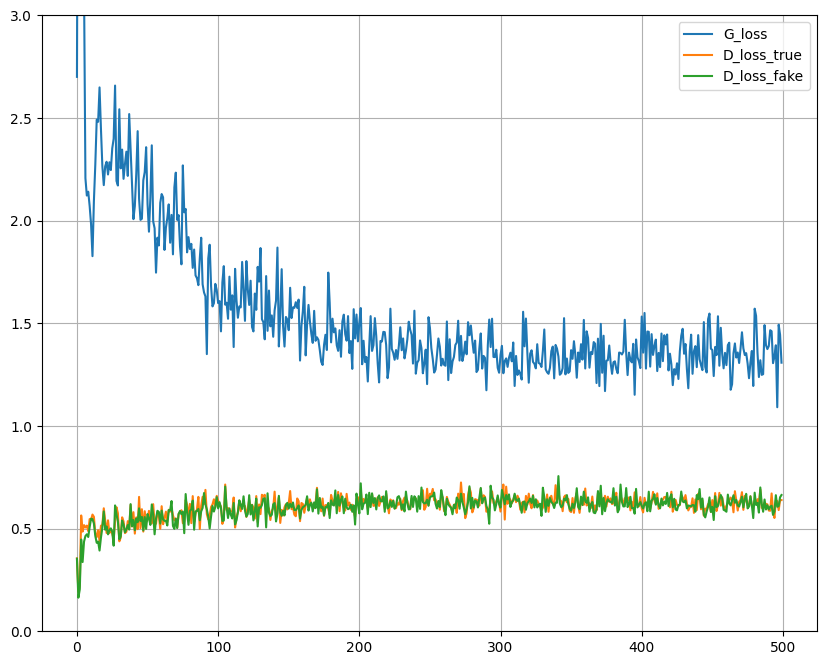

In [70]:
plot_losses(history, 3)

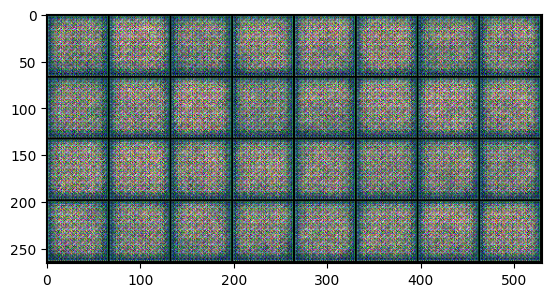

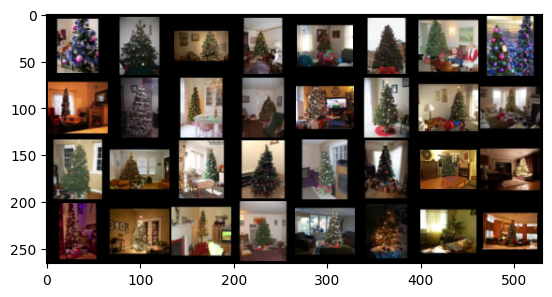

In [ ]:
noise = torch.randn(BATCH_SIZE, NUM_DIMS, device=device)
images_generated = gen(noise)
plot_figures(images_generated, 32)
images_original = next(iter(train_loader))[0]   
plot_figures(images_original, 32)


dict_keys(['disc_state_dict', 'gen_state_dict', 'disc_optimizer_state_dict', 'gen_optimizer_state_dict', 'epoch', 'history', 'accuracy'])
Loaded checkpoint from epoch 0


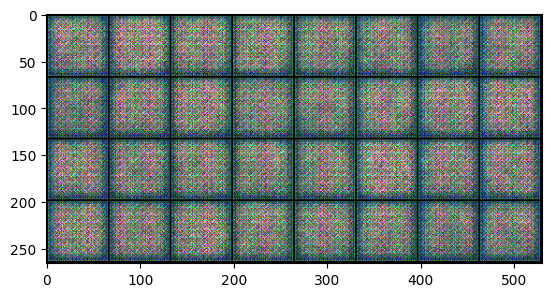

In [83]:
#To read a saved model checkpoint
# Load a checkpoint
checkpoint = torch.load("model64_epoch_0.pth", map_location=device)

# The checkpoint contains a dictionary with all saved items
print(checkpoint.keys())
# Output: dict_keys(['disc_state_dict', 'gen_state_dict', 
#                    'disc_optimizer_state_dict', 'gen_optimizer_state_dict',
#                    'epoch', 'history', 'accuracy'])

# Restore the models
gen.load_state_dict(checkpoint['gen_state_dict'])
disc.load_state_dict(checkpoint['disc_state_dict'])

# Restore optimizers (if you want to continue training)
gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
disc_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])

# Access saved metrics
history = checkpoint['history']
accuracy = checkpoint['accuracy']
saved_epoch = checkpoint['epoch']

print(f"Loaded checkpoint from epoch {saved_epoch}")

# Set models to evaluation mode for generating images
gen.eval()
disc.eval()

# Generate some images with the loaded generator
with torch.no_grad():
    noise = torch.randn(32, NUM_DIMS, device=device)
    generated_images = gen(noise)
    plot_figures(generated_images, 32)

dict_keys(['disc_state_dict', 'gen_state_dict', 'disc_optimizer_state_dict', 'gen_optimizer_state_dict', 'epoch', 'history', 'accuracy'])
Loaded checkpoint from epoch 100


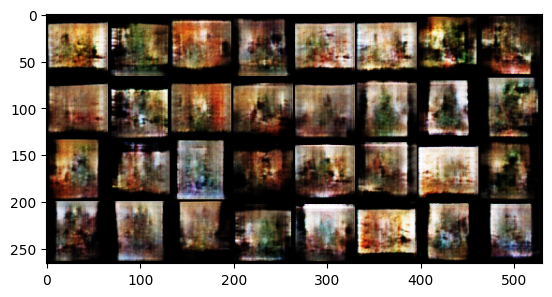

In [84]:
#To read a saved model checkpoint
# Load a checkpoint
checkpoint = torch.load("model64_epoch_100.pth", map_location=device)

# The checkpoint contains a dictionary with all saved items
print(checkpoint.keys())
# Output: dict_keys(['disc_state_dict', 'gen_state_dict', 
#                    'disc_optimizer_state_dict', 'gen_optimizer_state_dict',
#                    'epoch', 'history', 'accuracy'])

# Restore the models
gen.load_state_dict(checkpoint['gen_state_dict'])
disc.load_state_dict(checkpoint['disc_state_dict'])

# Restore optimizers (if you want to continue training)
gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
disc_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])

# Access saved metrics
history = checkpoint['history']
accuracy = checkpoint['accuracy']
saved_epoch = checkpoint['epoch']

print(f"Loaded checkpoint from epoch {saved_epoch}")

# Set models to evaluation mode for generating images
gen.eval()
disc.eval()

# Generate some images with the loaded generator
with torch.no_grad():
    noise = torch.randn(32, NUM_DIMS, device=device)
    generated_images = gen(noise)
    plot_figures(generated_images, 32)

dict_keys(['disc_state_dict', 'gen_state_dict', 'disc_optimizer_state_dict', 'gen_optimizer_state_dict', 'epoch', 'history', 'accuracy'])
Loaded checkpoint from epoch 200


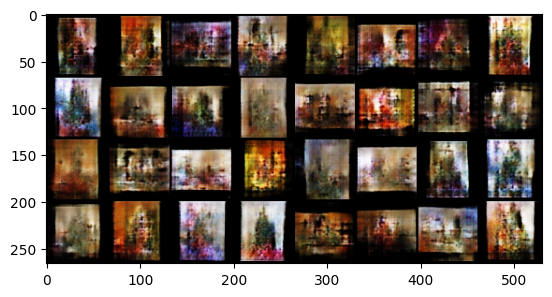

In [85]:
#To read a saved model checkpoint
# Load a checkpoint
checkpoint = torch.load("model64_epoch_200.pth", map_location=device)

# The checkpoint contains a dictionary with all saved items
print(checkpoint.keys())
# Output: dict_keys(['disc_state_dict', 'gen_state_dict', 
#                    'disc_optimizer_state_dict', 'gen_optimizer_state_dict',
#                    'epoch', 'history', 'accuracy'])

# Restore the models
gen.load_state_dict(checkpoint['gen_state_dict'])
disc.load_state_dict(checkpoint['disc_state_dict'])

# Restore optimizers (if you want to continue training)
gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
disc_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])

# Access saved metrics
history = checkpoint['history']
accuracy = checkpoint['accuracy']
saved_epoch = checkpoint['epoch']

print(f"Loaded checkpoint from epoch {saved_epoch}")

# Set models to evaluation mode for generating images
gen.eval()
disc.eval()

# Generate some images with the loaded generator
with torch.no_grad():
    noise = torch.randn(32, NUM_DIMS, device=device)
    generated_images = gen(noise)
    plot_figures(generated_images, 32)

dict_keys(['disc_state_dict', 'gen_state_dict', 'disc_optimizer_state_dict', 'gen_optimizer_state_dict', 'epoch', 'history', 'accuracy'])
Loaded checkpoint from epoch 300


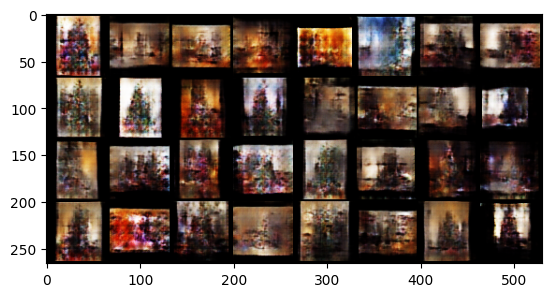

In [86]:
#To read a saved model checkpoint
# Load a checkpoint
checkpoint = torch.load("model64_epoch_300.pth", map_location=device)

# The checkpoint contains a dictionary with all saved items
print(checkpoint.keys())
# Output: dict_keys(['disc_state_dict', 'gen_state_dict', 
#                    'disc_optimizer_state_dict', 'gen_optimizer_state_dict',
#                    'epoch', 'history', 'accuracy'])

# Restore the models
gen.load_state_dict(checkpoint['gen_state_dict'])
disc.load_state_dict(checkpoint['disc_state_dict'])

# Restore optimizers (if you want to continue training)
gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
disc_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])

# Access saved metrics
history = checkpoint['history']
accuracy = checkpoint['accuracy']
saved_epoch = checkpoint['epoch']

print(f"Loaded checkpoint from epoch {saved_epoch}")

# Set models to evaluation mode for generating images
gen.eval()
disc.eval()

# Generate some images with the loaded generator
with torch.no_grad():
    noise = torch.randn(32, NUM_DIMS, device=device)
    generated_images = gen(noise)
    plot_figures(generated_images, 32)

dict_keys(['disc_state_dict', 'gen_state_dict', 'disc_optimizer_state_dict', 'gen_optimizer_state_dict', 'epoch', 'history', 'accuracy'])
Loaded checkpoint from epoch 400


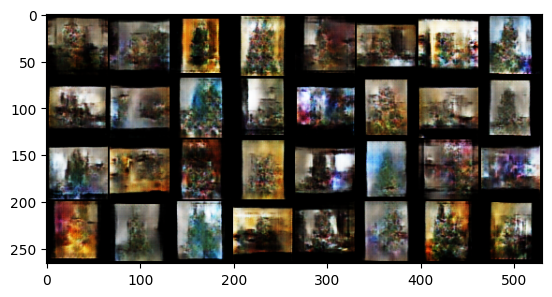

In [87]:
#To read a saved model checkpoint
# Load a checkpoint
checkpoint = torch.load("model64_epoch_400.pth", map_location=device)

# The checkpoint contains a dictionary with all saved items
print(checkpoint.keys())
# Output: dict_keys(['disc_state_dict', 'gen_state_dict', 
#                    'disc_optimizer_state_dict', 'gen_optimizer_state_dict',
#                    'epoch', 'history', 'accuracy'])

# Restore the models
gen.load_state_dict(checkpoint['gen_state_dict'])
disc.load_state_dict(checkpoint['disc_state_dict'])

# Restore optimizers (if you want to continue training)
gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
disc_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])

# Access saved metrics
history = checkpoint['history']
accuracy = checkpoint['accuracy']
saved_epoch = checkpoint['epoch']

print(f"Loaded checkpoint from epoch {saved_epoch}")

# Set models to evaluation mode for generating images
gen.eval()
disc.eval()

# Generate some images with the loaded generator
with torch.no_grad():
    noise = torch.randn(32, NUM_DIMS, device=device)
    generated_images = gen(noise)
    plot_figures(generated_images, 32)